In [199]:
import os
import warnings
warnings.filterwarnings("ignore")

# 데이터프레임 관련 라이브러리
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt

# 시각화 관련 라이브러리
import pydeck as pdk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc #폰트 설정
%matplotlib inline
matplotlib.rcParams['font.family'] = "NanumGothic" # 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False #마이너스 깨짐 방지

# 모델링 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor
import xgboost as xgb
import catboost as cb
from sklearn.metrics import r2_score, mean_squared_error
import joblib

In [200]:
import sklearn
sklearn.__version__

'0.23.2'

In [201]:
# 시각화 위한 환경설정
mapbox_key = 'pk.eyJ1IjoicWlxaTY1NCIsImEiOiJja2xnYW0xdWgyMmUyMnVxZWl2NGJpYng3In0.VIYWYBixklc-pAM9w7AjMA'

center = [127.6958882, 34.9406968] 
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=10)

def poly2list(df,geo_col='geometry'):
    geo_list = []
    for i in range(len(df)):
        geo_point = df.loc[i,geo_col]
        if geo_point.type=='MultiPolygon':
            geo2 = [[list(xy) for xy in geo.exterior.coords] for geo in geo_point]
            geo_list.append(geo2)
        elif geo_point.type=='Polygon':
            geo2 = [list(xy) for xy in geo_point.exterior.coords]
            geo_list.append(geo2)
    df['geometry2'] = geo_list
    return df

# 모델링

In [251]:
# 후보지 데이터 불러오기
data=pd.read_csv('최종데이터셋_BDTYPCD.csv')
data['area'] = data['area'].round(6)
data['trash'] = data['trash'].round(4)

print(data.shape)

# geoDataFrame으로 변환
data['geometry'] = data['geometry'].apply(wkt.loads)
data = gpd.GeoDataFrame(data, crs='epsg:4326')
data.dtypes

(598, 18)


gid             object
val            float64
geometry      geometry
area           float64
cap              int64
trash          float64
분리수거장 개수         int64
emd_nm          object
land_value     float64
생산가능(남)        float64
생산가능(여)        float64
유소년(남)         float64
유소년(여)         float64
고령(남)          float64
고령(여)          float64
floor            int64
1종근린시설           int64
2종근린시설           int64
dtype: object

In [252]:
# trash 값이 0보다 큰 데이터만 분석에 사용
dataset = data[data['trash'] > 0].reset_index(drop=True)
dataset.shape

(299, 18)

In [253]:
dataset.columns

Index(['gid', 'val', 'geometry', 'area', 'cap', 'trash', '분리수거장 개수', 'emd_nm',
       'land_value', '생산가능(남)', '생산가능(여)', '유소년(남)', '유소년(여)', '고령(남)',
       '고령(여)', 'floor', '1종근린시설', '2종근린시설'],
      dtype='object')

In [254]:
dataset.describe()

,val,area,cap,trash,분리수거장 개수,land_value,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,1종근린시설,2종근린시설
count,299.000000,299.000000,299.0,299.000000,299.000000,2.990000e+02,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,296.735786,0.999620,1.0,412.964795,0.819398,3.050366e+05,115.936455,106.000000,22.632107,21.749164,11.016722,13.635452,37.632107,0.698997,1.471572
std,302.725362,0.714840,0.0,531.175821,0.671189,2.254194e+05,120.367388,110.698393,29.087898,28.591674,11.688191,14.524599,24.357346,1.422388,2.510721
min,0.000000,0.000098,1.0,0.021600,0.000000,2.054360e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.500000,0.365038,1.0,74.541850,0.000000,1.385039e+05,19.500000,13.500000,0.000000,0.000000,0.000000,0.000000,19.500000,0.000000,0.000000
50%,234.000000,0.923214,1.0,192.081400,1.000000,2.652997e+05,93.000000,82.000000,13.000000,12.000000,9.000000,11.000000,30.000000,0.000000,0.000000
75%,423.500000,1.568984,1.0,555.683400,1.000000,4.260706e+05,171.000000,157.000000,34.000000,32.500000,18.000000,22.000000,50.000000,1.000000,2.000000
max,2563.000000,2.971976,1.0,2620.734300,3.000000,1.429192e+06,1025.000000,925.000000,231.000000,211.000000,65.000000,62.000000,120.000000,9.000000,17.000000


<AxesSubplot:xlabel='land_value', ylabel='Density'>

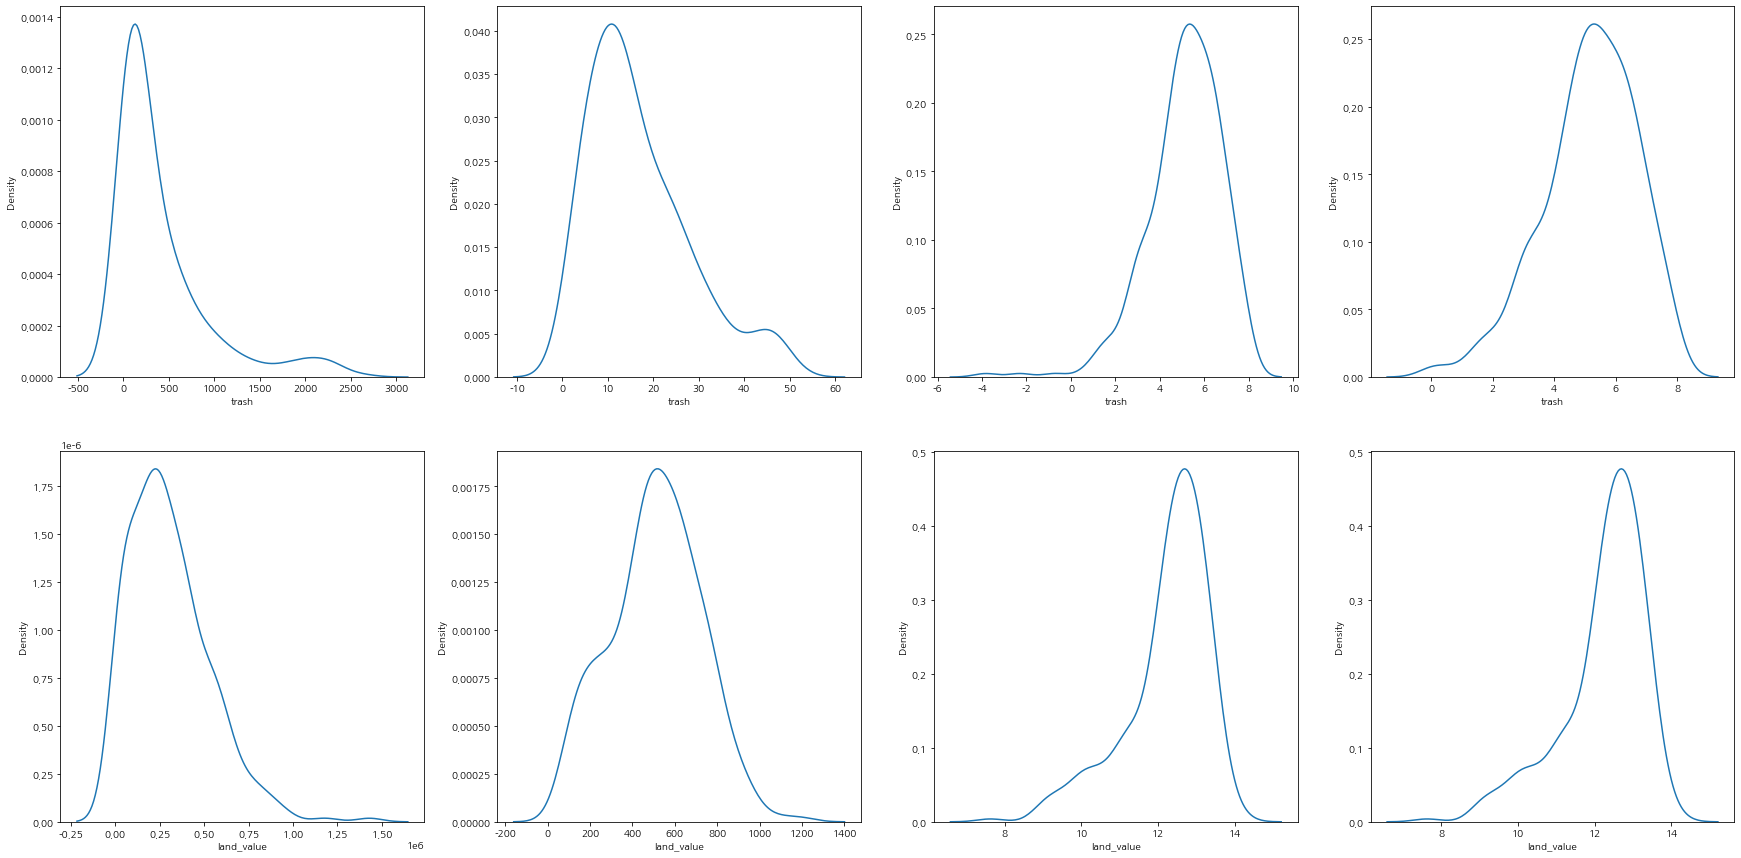

In [255]:
# 연속형 변수(쓰레기양, 공시지가)분포 확인
f, ax = plt.subplots(2,4, figsize=(30,15))

# trash dist'n
sns.kdeplot(dataset['trash'], ax=ax[0,0]) # 원 데이터
sns.kdeplot(np.sqrt(dataset['trash']), ax=ax[0,1]) # sqrt tranfrom
sns.kdeplot(np.log(dataset['trash']), ax=ax[0,2]) # log transform
sns.kdeplot(np.log1p(dataset['trash']), ax=ax[0,3]) # log1p transform

# land_value dist'n
sns.kdeplot(dataset['land_value'], ax=ax[1,0]) # 원 데이터
sns.kdeplot(np.sqrt(dataset['land_value']), ax=ax[1,1]) # sqrt tranfrom
sns.kdeplot(np.log(dataset['land_value']), ax=ax[1,2]) # log transform
sns.kdeplot(np.log(dataset['land_value']+1), ax=ax[1,3]) # log1p transform

In [256]:
# 정규분포에 근사하는 방법으로 변환
dataset['trash']=np.log1p(dataset['trash']) # log1p transform
dataset['land_value']=np.sqrt(dataset['land_value']) # sqrt transform

<AxesSubplot:>

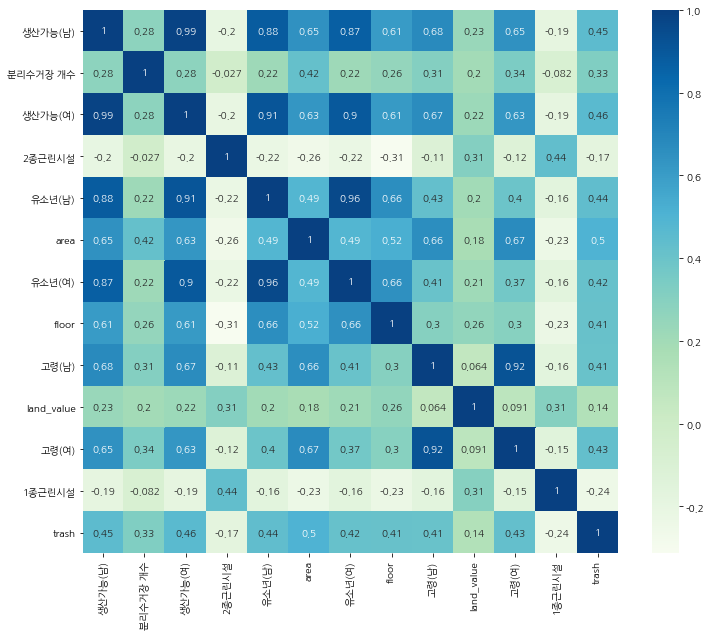

In [257]:
# 상관계수 기반 히트맵
dataset = dataset[[  
                   '생산가능(남)', '분리수거장 개수', '생산가능(여)', '2종근린시설','유소년(남)' ,'area', '유소년(여)', 'floor', '고령(남)','land_value', '고령(여)', 
                   '1종근린시설', 'trash']]

plt.figure(figsize=(12,10))
sns.heatmap(dataset.corr(), annot=True, cmap='GnBu')

In [258]:
# 분석에 사용할 특성만 남김
df = dataset[['trash','분리수거장 개수', 'land_value','area',
              '생산가능(남)', '생산가능(여)', '유소년(남)', '유소년(여)', '고령(남)', '고령(여)',
              'floor','2종근린시설', '1종근린시설']]
display(df.head())

,trash,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설
0,4.084240,0,154.832361,1.072426,34.0,29.0,0.0,0.0,8.0,12.0,20,0,1
1,5.400863,1,111.333283,1.120710,156.0,158.0,67.0,61.0,7.0,11.0,68,0,0
2,4.325402,0,840.697960,0.679456,166.0,145.0,32.0,26.0,12.0,14.0,17,8,2
3,3.072244,0,594.549165,0.516846,38.0,13.0,0.0,0.0,7.0,0.0,25,6,0
4,4.693166,0,618.278513,1.560743,326.0,292.0,62.0,60.0,28.0,27.0,36,0,0


### Pacaret Modeling
* 모델 후보를 골라내는 지표로 삼음

In [259]:
from pycaret.regression import *

# 환경설정
setup = setup(data = df, 
              target = 'trash', 
              fold=9, 
              silent = True, 
              session_id = 24, 
              train_size=0.8, 
              normalize=True,
              numeric_features=["분리수거장 개수", "floor", "1종근린시설", "2종근린시설"]
     )

print('setup_compelete')

,Description,Value
0,session_id,24
1,Target,trash
2,Original Data,"(299, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(239, 12)"


setup_compelete


In [260]:
# 전체적인 모델 성능 확인(각 CV 값들의 평균값으로 도출되는 값)
compare_models(sort = 'R2', exclude=['catboost'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.9794,1.3232,1.1397,0.3866,0.2121,0.6053,0.1111
et,Extra Trees Regressor,0.9659,1.3739,1.1534,0.3747,0.2172,0.8180,0.2078
gbr,Gradient Boosting Regressor,0.9906,1.3574,1.1494,0.3711,0.2133,0.5358,0.0922
rf,Random Forest Regressor,0.9938,1.3952,1.1648,0.3575,0.2129,0.6083,0.2867
br,Bayesian Ridge,1.0129,1.5357,1.2201,0.3186,0.2423,0.9546,0.0133
ridge,Ridge Regression,1.0108,1.5460,1.2231,0.3136,0.2419,0.9080,0.0133
lr,Linear Regression,1.0119,1.5517,1.2252,0.3109,0.2422,0.9058,0.0133
lightgbm,Light Gradient Boosting Machine,1.0102,1.5302,1.2115,0.3080,0.2346,0.9544,0.0378
huber,Huber Regressor,1.0185,1.5595,1.2289,0.3058,0.2425,0.8896,0.0244
knn,K Neighbors Regressor,1.0387,1.6787,1.2723,0.2472,0.2461,1.0193,0.0156


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=24)

* 상위모델(top 4)인 AdaBoostRegressor, Extra Trees Regressor, Gradient Boosting Regressor, Random Forest Regressor 중심으로 심층 파악
* default model / tuning model / ensemble model 순으로 확인

* AdaBoost Regressor

In [261]:
ada = create_model('ada')
predict_model(ada)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8621,1.0368,1.0182,0.4224,0.1866,0.2076
1,1.1701,1.6797,1.2960,0.5478,0.2914,3.5744
2,0.9763,1.2583,1.1217,0.3769,0.1921,0.1975
3,0.8753,1.0375,1.0186,0.5393,0.2179,0.3112
4,0.8409,0.9636,0.9816,0.4652,0.1660,0.1797
5,1.2138,2.1741,1.4745,0.3726,0.3012,0.3835
6,1.0492,1.4742,1.2142,0.0448,0.2000,0.2143
7,0.9593,1.2994,1.1399,0.2010,0.1913,0.2011
8,0.8677,0.9853,0.9926,0.5090,0.1628,0.1787
Mean,0.9794,1.3232,1.1397,0.3866,0.2121,0.6053


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.9654,1.3445,1.1595,0.4496,0.2635,0.6868


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.877434
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.965187
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.642707
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.472649
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.548057
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.180105
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.145037
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,4.262488
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.633319
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.075398


In [262]:
tuned_ada=tune_model(ada)
predict_model(tuned_ada)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8311,0.9222,0.9603,0.4862,0.1786,0.2009
1,1.1957,1.8058,1.3438,0.5138,0.3239,4.6152
2,0.9226,1.1711,1.0822,0.4201,0.1774,0.1838
3,0.8667,1.0002,1.0001,0.5559,0.2078,0.2919
4,0.9056,1.0666,1.0328,0.4081,0.1782,0.1988
5,1.2070,2.1319,1.4601,0.3848,0.2995,0.3783
6,0.9963,1.3438,1.1592,0.1293,0.1927,0.2050
7,0.9152,1.2073,1.0988,0.2576,0.1830,0.1895
8,0.8497,0.9553,0.9774,0.5239,0.1609,0.1757
Mean,0.9656,1.2894,1.1239,0.4088,0.2113,0.7155


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.9737,1.3994,1.1830,0.4271,0.2683,0.7148


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.934349
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,6.050153
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.906828
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.547544
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.512181
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.171691
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.228402
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,4.174462
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.784033
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.136001


In [263]:
ensemble_ada = ensemble_model(tuned_ada, method='Boosting')
predict_model(ensemble_ada)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8525,0.9129,0.9554,0.4914,0.1760,0.2026
1,1.2548,1.9758,1.4056,0.4681,0.3518,5.5869
2,0.9175,1.0861,1.0422,0.4622,0.1711,0.1807
3,0.7569,0.7737,0.8796,0.6564,0.1986,0.2809
4,0.8923,0.9721,0.9859,0.4605,0.1690,0.1922
5,1.2054,2.2134,1.4878,0.3613,0.3033,0.3818
6,1.0294,1.4136,1.1890,0.0840,0.1973,0.2103
7,0.9491,1.2498,1.1179,0.2315,0.1871,0.1958
8,0.8768,1.0262,1.0130,0.4886,0.1695,0.1846
Mean,0.9705,1.2915,1.1196,0.4115,0.2137,0.8240


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.9658,1.3220,1.1498,0.4588,0.2594,0.6833


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,6.002789
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.834817
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.918758
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.463658
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.366258
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.296388
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.391029
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,4.007132
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.584733
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,5.934064


* Extra Trees Regressor

In [264]:
et=create_model('et')
predict_model(et);

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7941,0.8179,0.9044,0.5443,0.1602,0.1802
1,1.1702,1.9452,1.3947,0.4763,0.3440,5.5588
2,1.0461,1.5889,1.2605,0.2132,0.2127,0.2118
3,0.8192,0.8444,0.9189,0.6251,0.1806,0.2441
4,0.9926,1.3196,1.1487,0.2677,0.1933,0.2124
5,1.1927,2.4010,1.5495,0.3071,0.3228,0.4062
6,0.9119,1.3142,1.1464,0.1485,0.1905,0.1835
7,0.9511,1.2581,1.1217,0.2264,0.1928,0.1922
8,0.8149,0.8758,0.9358,0.5635,0.1584,0.1724
Mean,0.9659,1.3739,1.1534,0.3747,0.2172,0.8180


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8847,1.3172,1.1477,0.4608,0.2631,0.7433


In [265]:
tuned_et=tune_model(et)
predict_model(tuned_et);

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7702,0.8251,0.9084,0.5403,0.1660,0.1795
1,1.3402,2.3704,1.5396,0.3618,0.3876,6.5485
2,0.9005,1.1060,1.0517,0.4523,0.1746,0.1769
3,0.8451,1.0176,1.0088,0.5481,0.2482,0.3891
4,0.9175,1.1613,1.0776,0.3555,0.1815,0.1905
5,1.2614,2.3670,1.5385,0.3170,0.3314,0.4394
6,0.9250,1.2694,1.1267,0.1775,0.1825,0.1798
7,0.9623,1.2948,1.1379,0.2038,0.1905,0.1940
8,0.8064,0.8968,0.9470,0.5530,0.1557,0.1652
Mean,0.9698,1.3676,1.1485,0.3899,0.2242,0.9403


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8809,1.1793,1.0860,0.5172,0.2584,0.7324


In [266]:
ensemble_et = ensemble_model(tuned_et, method='Boosting')
predict_model(ensemble_et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7908,0.8815,0.9389,0.5089,0.1737,0.1884
1,1.3504,2.3369,1.5287,0.3708,0.3831,6.4752
2,0.9063,1.1803,1.0864,0.4155,0.1833,0.1808
3,0.8619,1.0593,1.0292,0.5296,0.2501,0.3947
4,0.8544,1.0432,1.0214,0.4211,0.1707,0.1794
5,1.2275,2.2018,1.4838,0.3646,0.3158,0.4156
6,0.9493,1.3104,1.1447,0.1510,0.1885,0.1879
7,0.9773,1.2960,1.1384,0.2030,0.1926,0.2022
8,0.7908,0.8828,0.9396,0.5600,0.1550,0.1617
Mean,0.9676,1.3547,1.1457,0.3916,0.2236,0.9318


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8913,1.1830,1.0877,0.5157,0.2532,0.6926


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,6.117915
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.927730
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.521302
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.602445
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.226442
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.343592
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.709428
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,4.214964
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.363474
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.038428


* Gradient Boosting Regressor

In [267]:
gbr=create_model('gbr')
predict_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7846,0.8308,0.9115,0.5371,0.1658,0.1864
1,1.1652,1.7483,1.3222,0.5293,0.2855,3.0006
2,1.1416,1.6957,1.3022,0.1603,0.2410,0.2361
3,0.8429,0.9798,0.9899,0.5649,0.1884,0.2410
4,0.9185,1.1432,1.0692,0.3656,0.1865,0.1954
5,1.2303,2.1999,1.4832,0.3652,0.3043,0.3942
6,1.0430,1.5244,1.2347,0.0123,0.2015,0.2066
7,0.9955,1.2983,1.1394,0.2017,0.1966,0.2030
8,0.7936,0.7959,0.8921,0.6033,0.1504,0.1587
Mean,0.9906,1.3574,1.1494,0.3711,0.2133,0.5358


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.8916,1.2633,1.1240,0.4828,0.2530,0.6318


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.577666
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,6.022020
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.634294
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,6.177278
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.405387
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.059031
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.849683
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,4.081761
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,6.084586
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.265929


In [268]:
tuned_gbr=tune_model(gbr)
predict_model(tuned_gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7099,0.6886,0.8298,0.6163,0.1458,0.1600
1,1.2078,1.9279,1.3885,0.4810,0.3145,4.2374
2,1.0368,1.5040,1.2264,0.2552,0.2127,0.2129
3,0.8768,0.9882,0.9941,0.5612,0.1749,0.2153
4,0.9113,1.3620,1.1671,0.2441,0.1941,0.1879
5,1.2553,2.2366,1.4955,0.3546,0.3015,0.3809
6,1.0122,1.5187,1.2323,0.0160,0.2023,0.2017
7,1.0554,1.5489,1.2445,0.0476,0.2224,0.2114
8,0.8756,1.0438,1.0216,0.4798,0.1606,0.1708
Mean,0.9935,1.4243,1.1778,0.3395,0.2143,0.6643


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.8591,1.1652,1.0794,0.5230,0.2465,0.6521


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.793820
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.811315
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.351870
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,6.329480
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.838260
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.542247
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.528373
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,3.698009
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.672238
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.214998


In [269]:
ensemble_gbr = ensemble_model(tuned_gbr, method='Boosting')
predict_model(ensemble_gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8364,0.9091,0.9535,0.4935,0.1692,0.1930
1,1.3266,2.2391,1.4964,0.3971,0.3538,5.4009
2,0.8878,1.2065,1.0984,0.4025,0.1840,0.1789
3,0.8641,1.0010,1.0005,0.5555,0.2038,0.2884
4,0.9149,1.1318,1.0638,0.3719,0.1798,0.1948
5,1.1421,2.1562,1.4684,0.3778,0.3010,0.3732
6,1.0274,1.5165,1.2315,0.0174,0.2050,0.2045
7,0.9959,1.3228,1.1501,0.1866,0.1991,0.2039
8,0.8684,0.9893,0.9946,0.5069,0.1614,0.1784
Mean,0.9849,1.3858,1.1619,0.3677,0.2175,0.8018


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.8839,1.2030,1.0968,0.5075,0.2449,0.6250


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.663243
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.674933
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.658286
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.982354
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.688344
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.105641
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.595052
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,3.657302
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.775590
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.139759


* Random Forest Regressor

In [270]:
rf=create_model('rf')
predict_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7723,0.8345,0.9135,0.5350,0.1690,0.1857
1,1.2073,1.8879,1.3740,0.4917,0.2971,3.6709
2,1.0179,1.3385,1.1569,0.3372,0.1982,0.2074
3,0.8512,1.0339,1.0168,0.5409,0.1904,0.2387
4,0.9652,1.2401,1.1136,0.3118,0.1896,0.2056
5,1.2280,2.3892,1.5457,0.3106,0.3121,0.3761
6,1.0672,1.5788,1.2565,-0.0230,0.2054,0.2113
7,1.0224,1.4055,1.1855,0.1358,0.2048,0.2134
8,0.8123,0.8483,0.9210,0.5772,0.1493,0.1657
Mean,0.9938,1.3952,1.1648,0.3575,0.2129,0.6083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.8644,1.1504,1.0726,0.5291,0.2436,0.6271


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.560635
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.948549
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.903667
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.937520
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.441917
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.007539
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.357099
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,3.498665
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.620318
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.036794


In [271]:
tuned_rf=tune_model(rf)
predict_model(tuned_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7748,0.8248,0.9082,0.5405,0.1681,0.1838
1,1.2456,1.9556,1.3984,0.4735,0.3470,5.4463
2,0.8931,1.1082,1.0527,0.4512,0.1712,0.1683
3,0.8611,0.9480,0.9737,0.5790,0.2250,0.3394
4,0.9516,1.2346,1.1111,0.3149,0.1864,0.2007
5,1.2869,2.2218,1.4906,0.3589,0.3057,0.3914
6,0.9615,1.3725,1.1715,0.1107,0.1900,0.1885
7,1.0263,1.5000,1.2247,0.0776,0.2061,0.2119
8,0.8507,0.9835,0.9917,0.5098,0.1574,0.1693
Mean,0.9835,1.3499,1.1470,0.3796,0.2174,0.8111


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.9429,1.2623,1.1235,0.4832,0.2508,0.6295


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.886982
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.800723
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.366273
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.545818
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.436750
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.211894
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.681686
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,4.436750
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.225865
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,6.021857


In [272]:
ensemble_rf=ensemble_model(rf, method='Boosting')
predict_model(ensemble_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7970,0.8363,0.9145,0.5341,0.1663,0.1871
1,1.2275,1.8628,1.3648,0.4985,0.2960,3.6260
2,0.9512,1.2149,1.1022,0.3984,0.1863,0.1899
3,0.8996,1.1305,1.0632,0.4980,0.2109,0.2747
4,0.9796,1.2220,1.1054,0.3219,0.1879,0.2097
5,1.1748,2.2272,1.4924,0.3573,0.3012,0.3697
6,1.0654,1.5558,1.2473,-0.0081,0.2062,0.2140
7,0.9749,1.2938,1.1375,0.2044,0.1914,0.2011
8,0.8515,0.9267,0.9626,0.5382,0.1560,0.1749
Mean,0.9913,1.3633,1.1544,0.3714,0.2114,0.6052


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.9121,1.3163,1.1473,0.4611,0.2625,0.6988


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설,trash,Label
0,0.317847,-0.339927,2.338540,0.073053,0.134834,-0.382682,-0.131849,1.816859,1.983460,0.042055,0.217219,0.224893,5.116644,5.737682
1,0.317847,0.691341,0.226938,0.009431,-0.033367,0.190861,0.567553,-0.923544,-0.927295,0.379909,-0.569376,-0.482337,7.399510,5.963360
2,0.317847,0.489248,-0.534851,-0.454100,-0.537971,-0.573863,-0.481550,0.072966,0.291160,-0.338030,3.363599,0.224893,5.609022,5.756578
3,-1.201460,-1.904256,-0.626189,-0.326856,-0.142203,-0.076792,-0.209560,-0.093119,-0.385759,-0.760347,-0.569376,-0.482337,4.844045,5.796507
4,-1.201460,1.824111,-0.617652,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-0.844811,1.790409,0.224893,4.214448,4.258308
5,1.837153,0.588144,-0.742259,-0.445011,-0.181780,-0.497390,-0.598117,-0.176161,-0.182683,-0.971506,-0.569376,-0.482337,6.959898,5.199147
6,1.837153,0.494593,2.177095,8.271195,8.109557,7.991045,7.367294,3.477709,3.269607,2.449261,-0.569376,-0.482337,5.650079,6.317855
7,-1.201460,0.384643,-0.668241,-0.699499,-0.913951,-0.841516,-0.831251,-0.342246,-0.927295,-0.549189,1.790409,-0.482337,3.072244,3.916866
8,0.317847,-0.316846,-0.923927,-0.499544,-0.488500,0.114389,-0.092993,-0.923544,-0.927295,0.633299,0.217219,0.224893,6.371325,5.559367
9,0.317847,1.210469,0.687925,1.336403,1.510128,0.687932,0.606408,1.401646,1.848076,0.548835,-0.176079,0.932124,6.540597,5.977054


## Pycaret 기반 모델 생성

In [273]:
# train/test split
y = df['trash']
X = df.drop(columns=['trash'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

X_col = X_train.columns

# 스케일링 진행
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_col)
scaled_X_test = scaler.transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_col)

In [274]:
scaled_X_train.head()

,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설
0,1.837153,1.267030,1.479729,0.300274,0.332718,0.649695,0.412130,-0.923544,-0.182683,2.449261,-0.569376,-0.482337
1,-1.201460,0.248085,-1.147104,-0.644966,-0.597336,-0.420918,-0.598117,-0.923544,-0.927295,0.084287,-0.569376,-0.482337
2,0.317847,1.137215,1.258797,2.490687,2.885421,2.485032,3.287449,0.571221,0.358852,2.153639,-0.569376,-0.482337
3,0.317847,0.067064,-0.804287,-0.435923,-0.429135,-0.344446,-0.598117,-0.010076,0.291160,-0.971506,0.610516,0.224893
4,0.317847,-1.027100,-0.634527,-0.654055,-0.607230,-0.306210,-0.403839,-0.923544,-0.927295,0.928920,-0.569376,-0.482337


In [275]:
# pycaret에서 얻은 파라미터 적용한 모델 생성
model_ada=ada #0.4427
model_ada_tune=tuned_ada #0.4411
model_ada_es=ensemble_ada #0.4674

model_gbr=gbr #0.4828
model_gbr_tune=tuned_gbr #0.5230
model_gbr_es=ensemble_gbr #0.4863

model_et=et #0.4608
model_et_tune=tuned_et #0.5172
model_et_es=ensemble_et #0.5157

model_rf=rf #0.5291	
model_rf_tune=tuned_rf #0.4830
model_rf_es=ensemble_rf #0.4620

#### 최적의 모델 생성해내기 위한 과정

In [276]:
model, r2, rmse = [],[],[]

def model_score(name, r2_S, rmse_s):
    
    model.append(name)
    r2.append(r2_S)
    rmse.append(rmse_s)

In [277]:
model1=VotingRegressor(estimators=[
    ('et_',model_et_tune),
    ('_et_',model_et_es),
    ('rf',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model1.fit(scaled_X_train, y_train)


pred_train=model1.predict(scaled_X_train)
pred_test=model1.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model1',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8164433808162037
0.5137095036594173
1.0899008433289572


In [278]:
model2=VotingRegressor(estimators=[
    ('et_',model_et_tune),
    ('_et_',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model2.fit(scaled_X_train, y_train)


pred_train=model2.predict(scaled_X_train)
pred_test=model2.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model2',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8534563168967348
0.5145877865822484
1.0889161706780541


In [279]:
model3=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),
    ('_et_',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model3.fit(scaled_X_train, y_train)


pred_train=model3.predict(scaled_X_train)
pred_test=model3.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model3',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8222153265457905
0.5188221316411086
1.0841563540674284


In [280]:
model4=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model4.fit(scaled_X_train, y_train)


pred_train=model4.predict(scaled_X_train)
pred_test=model4.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model4',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.7995333194172768
0.520454034236153
1.082316348204355


In [281]:
model5=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model5.fit(scaled_X_train, y_train)


pred_train=model5.predict(scaled_X_train)
pred_test=model5.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model5',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8169190695110886
0.5217515064702618
1.0808511846340565


In [282]:
model6=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model6.fit(scaled_X_train, y_train)


pred_train=model6.predict(scaled_X_train)
pred_test=model6.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model6',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8440970948092095
0.5229412046412506
1.0795059766628092


In [283]:
model7=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model7.fit(scaled_X_train, y_train)


pred_train=model7.predict(scaled_X_train)
pred_test=model7.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model7',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8357048612538241
0.5238056853594342
1.0785274439702135


In [284]:
model8=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model8.fit(scaled_X_train, y_train)


pred_train=model8.predict(scaled_X_train)
pred_test=model8.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model8',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8357048612538241
0.5238056853594342
1.0785274439702135


In [285]:
model9=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model9.fit(scaled_X_train, y_train)


pred_train=model9.predict(scaled_X_train)
pred_test=model9.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model9',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8526558428805211
0.5238881475016681
1.0784340561121466


In [286]:
model10=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model10.fit(scaled_X_train, y_train)


pred_train=model10.predict(scaled_X_train)
pred_test=model10.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model10',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.845957724915153
0.5246166450250278
1.077608685676492


In [287]:
model11=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),('et_5',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model11.fit(scaled_X_train, y_train)


pred_train=model11.predict(scaled_X_train)
pred_test=model11.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model11',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8395201098161877
0.525234809122959
1.076907824268243


In [288]:
model12=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model12.fit(scaled_X_train, y_train)


pred_train=model12.predict(scaled_X_train)
pred_test=model12.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model12',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8162046462062043
0.5268950141763513
1.0750232573285532


In [289]:
model13=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('et_10',model_et_tune),('et_11',model_et_tune),('et_12',model_et_tune),('et_13',model_et_tune),('et_14',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es)
                                  ])

model13.fit(scaled_X_train, y_train)


pred_train=model13.predict(scaled_X_train)
pred_test=model13.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model13',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.7918141709502666
0.5278367174927856
1.0739528213104892


In [290]:
model14=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('et_10',model_et_tune),('et_11',model_et_tune),('et_12',model_et_tune),('et_13',model_et_tune),('et_14',model_et_tune),
    ('et_15',model_et_tune),('et_16',model_et_tune),('et_17',model_et_tune),('et_18',model_et_tune),('et_19',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es),
                                  ])

model14.fit(scaled_X_train, y_train)


pred_train=model14.predict(scaled_X_train)
pred_test=model14.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model14',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.7716429729631165
0.5281248095155183
1.0736251333459421


In [291]:
model15=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('et_10',model_et_tune),('et_11',model_et_tune),('et_12',model_et_tune),('et_13',model_et_tune),('et_14',model_et_tune),
    ('et_15',model_et_tune),('et_16',model_et_tune),('et_17',model_et_tune),('et_18',model_et_tune),('et_19',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf15',model_rf),('rf16',model_rf),('rf17',model_rf),('rf18',model_rf),('rf19',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es),
                                  ])

model15.fit(scaled_X_train, y_train)


pred_train=model15.predict(scaled_X_train)
pred_test=model15.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model15',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.7906480874215293
0.5285944542520975
1.0730907251747372


In [292]:
model16=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('et_10',model_et_tune),('et_11',model_et_tune),('et_12',model_et_tune),('et_13',model_et_tune),('et_14',model_et_tune),
    ('et_15',model_et_tune),('et_16',model_et_tune),('et_17',model_et_tune),('et_18',model_et_tune),('et_19',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf15',model_rf),('rf16',model_rf),('rf17',model_rf),('rf18',model_rf),('rf19',model_rf),
    ('rf20',model_rf),('rf21',model_rf),('rf22',model_rf),('rf23',model_rf),('rf24',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es),
                                  ])

model16.fit(scaled_X_train, y_train)


pred_train=model16.predict(scaled_X_train)
pred_test=model16.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model16',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.8053697684443085
0.5287134750034793
1.0729552493320256


In [293]:
model17=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('et_10',model_et_tune),('et_11',model_et_tune),('et_12',model_et_tune),('et_13',model_et_tune),('et_14',model_et_tune),
    ('et_15',model_et_tune),('et_16',model_et_tune),('et_17',model_et_tune),('et_18',model_et_tune),('et_19',model_et_tune),
    ('et_20',model_et_tune),('et_21',model_et_tune),('et_22',model_et_tune),('et_23',model_et_tune),('et_24',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf15',model_rf),('rf16',model_rf),('rf17',model_rf),('rf18',model_rf),('rf19',model_rf),
    ('rf20',model_rf),('rf21',model_rf),('rf22',model_rf),('rf23',model_rf),('rf24',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es),
                                  ])

model17.fit(scaled_X_train, y_train)


pred_train=model17.predict(scaled_X_train)
pred_test=model17.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model17',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.7898547436960615
0.5290724860624607
1.072546499912482


In [294]:
model18=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('et_10',model_et_tune),('et_11',model_et_tune),('et_12',model_et_tune),('et_13',model_et_tune),('et_14',model_et_tune),
    ('et_15',model_et_tune),('et_16',model_et_tune),('et_17',model_et_tune),('et_18',model_et_tune),('et_19',model_et_tune),
    ('et_20',model_et_tune),('et_21',model_et_tune),('et_22',model_et_tune),('et_23',model_et_tune),('et_24',model_et_tune),
    ('et_25',model_et_tune),('et_26',model_et_tune),('et_27',model_et_tune),('et_28',model_et_tune),('et_29',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf15',model_rf),('rf16',model_rf),('rf17',model_rf),('rf18',model_rf),('rf19',model_rf),
    ('rf20',model_rf),('rf21',model_rf),('rf22',model_rf),('rf23',model_rf),('rf24',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),
    ('_gbr_',model_gbr_es),
                                  ])

model18.fit(scaled_X_train, y_train)


pred_train=model18.predict(scaled_X_train)
pred_test=model18.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model18',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.7761828953780836
0.5291833808236228
1.0724202099981324


In [295]:
model19=VotingRegressor(estimators=[
    ('et_',model_et_tune),('et_1',model_et_tune),('et_2',model_et_tune),('et_3',model_et_tune),('et_4',model_et_tune),
    ('et_5',model_et_tune),('et_6',model_et_tune),('et_7',model_et_tune),('et_8',model_et_tune),('et_9',model_et_tune),
    ('et_10',model_et_tune),('et_11',model_et_tune),('et_12',model_et_tune),('et_13',model_et_tune),('et_14',model_et_tune),
    ('et_15',model_et_tune),('et_16',model_et_tune),('et_17',model_et_tune),('et_18',model_et_tune),('et_19',model_et_tune),
    ('et_20',model_et_tune),('et_21',model_et_tune),('et_22',model_et_tune),('et_23',model_et_tune),('et_24',model_et_tune),
    ('et_25',model_et_tune),('et_26',model_et_tune),('et_27',model_et_tune),('et_28',model_et_tune),('et_29',model_et_tune),
    ('_et_',model_et_es),('_et_1',model_et_es),('_et_2',model_et_es),
    ('rf',model_rf),('rf1',model_rf),('rf2',model_rf),('rf3',model_rf),('rf4',model_rf),
    ('rf5',model_rf),('rf6',model_rf),('rf7',model_rf),('rf8',model_rf),('rf9',model_rf),
    ('rf10',model_rf),('rf11',model_rf),('rf12',model_rf),('rf13',model_rf),('rf14',model_rf),
    ('rf15',model_rf),('rf16',model_rf),('rf17',model_rf),('rf18',model_rf),('rf19',model_rf),
    ('rf20',model_rf),('rf21',model_rf),('rf22',model_rf),('rf23',model_rf),('rf24',model_rf),
    ('rf_',model_rf_tune),
    ('gbr',model_gbr),('gbr1',model_gbr),('gbr2',model_gbr),
    ('gbr_',model_gbr_tune),('gbr_1',model_gbr_tune),
    ('_gbr_',model_gbr_es),
                                  ])

model19.fit(scaled_X_train, y_train)


pred_train=model19.predict(scaled_X_train)
pred_test=model19.predict(scaled_X_test)
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
test_rmse = mean_squared_error(y_test,pred_test,squared=False)

model_score('model19',test_r2, test_rmse)
print(train_r2)
print(test_r2)
print(test_rmse)

0.779771512602916
0.5288006746226592
1.0728559831612752


In [296]:
pd.DataFrame({"model":model, "r2":r2, "rmse":rmse})

,model,r2,rmse
0,model1,0.513710,1.089901
1,model2,0.514588,1.088916
2,model3,0.518822,1.084156
3,model4,0.520454,1.082316
4,model5,0.521752,1.080851
5,model6,0.522941,1.079506
6,model7,0.523806,1.078527
7,model8,0.523806,1.078527
8,model9,0.523888,1.078434
9,model10,0.524617,1.077609


* model18이 최적의 모델이라 판단

## 최종 모델 및 예측

In [297]:
# 최종 모델 저장
joblib.dump(model18, 'f_model.pkl')

['f_model.pkl']

# 결과가 변할 수 있습니다.
- 같은 결과를 보시려면 추가제출 목록txt를 확인하여 같은 모델을 사용해주세요
- 이후 코드에서 저장후, 업로드 되는 파일 또한 같은 결과를 보기 위해선 마찬가지로 추가제출목록txt를 확인해주세요

In [298]:
mymodel=joblib.load('f_model.pkl')

In [299]:
len(mymodel.estimators)

64

In [300]:
# 예측할 모든 데이터 불러오기 ( trash==0 인 데이터 포함하기 위함 )
dataset = data[['trash','분리수거장 개수', 'land_value','area',
                '생산가능(남)', '생산가능(여)', '유소년(남)', '유소년(여)', '고령(남)', '고령(여)', 
                'floor','2종근린시설', '1종근린시설']]

dataset['trash']=np.log(dataset['trash']+1) # log(x+1) transform
dataset['land_value']=np.sqrt(dataset['land_value']) # sqrt transform
print(dataset.shape)

(598, 13)


In [301]:
X_data = dataset.drop(columns=['trash'])

scaled_data = scaler.transform(X_data)
scaled_data = pd.DataFrame(scaled_data, columns=X_col)

print(scaled_data.shape)
scaled_data.head()

(598, 12)


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설
0,-1.201460,-1.652802,0.115051,-0.735855,-0.755643,-0.841516,-0.831251,-0.259204,-0.114991,-0.760347,-0.569376,0.224893
1,0.317847,-1.854357,0.183125,0.372985,0.520708,1.720309,1.538944,-0.342246,-0.182683,1.266774,-0.569376,-0.482337
2,-1.201460,1.525182,-0.438983,0.463874,0.392083,0.382042,0.178996,0.072966,0.020393,-0.887042,2.577004,0.932124
3,0.317847,-0.009392,2.370976,-0.417745,-0.567654,-0.612099,-0.442694,-0.010076,0.020393,-0.422494,-0.569376,-0.482337
4,-1.201460,1.268506,-1.386357,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-1.013737,0.610516,0.932124


In [302]:
model = mymodel.predict(scaled_X_train)

In [303]:
# 모델 적용 및 예측
final = data.copy()
final['pred'] = mymodel.predict(scaled_data)
final['pred2'] = np.expm1(final['pred']) # 타겟변수가 log1p 변환이 되어 있기 때문에 이를 다시 원래대로 돌려주기 위한 작업
final.to_csv('data_final',index=False)
final.head()

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,1종근린시설,2종근린시설,pred,pred2
0,라라077653,85.0,"MULTIPOLYGON (((127.58436 34.98258, 127.58437 ...",1.072426,1,58.3968,0,광양읍,23973.06,34.0,29.0,0.0,0.0,8.0,12.0,20,1,0,4.659991,104.635087
1,라라103639,456.0,"MULTIPOLYGON (((127.61283 34.96994, 127.61283 ...",1.120710,1,220.5976,1,광양읍,12395.10,156.0,158.0,67.0,61.0,7.0,11.0,68,0,0,5.696888,296.938823
2,라라177603,400.0,"MULTIPOLYGON (((127.69382 34.93737, 127.69382 ...",0.679456,1,74.5959,0,중동,706773.06,166.0,145.0,32.0,26.0,12.0,14.0,17,2,8,5.057742,156.235121
3,라라212603,154.0,"MULTIPOLYGON (((127.73215 34.93730, 127.73215 ...",2.672528,1,0.0000,1,금호동,259599.98,69.0,48.0,6.0,10.0,11.0,14.0,28,0,0,5.557272,258.115051
4,라라074646,0.0,"MULTIPOLYGON (((127.58107 34.97627, 127.58107 ...",0.007494,1,0.0000,0,광양읍,616700.45,0.0,0.0,0.0,0.0,0.0,0.0,14,2,3,2.145895,7.549693


In [304]:
final[['gid','pred','pred2']].head(5)

,gid,pred,pred2
0,라라077653,4.659991,104.635087
1,라라103639,5.696888,296.938823
2,라라177603,5.057742,156.235121
3,라라212603,5.557272,258.115051
4,라라074646,2.145895,7.549693


## 예측값 처리하기

# 위와 같은 이유로 제출한 최종결과와 값이 변할 수 있습니다.

In [305]:
# 저장된 예측 데이터 불러오기
final = pd.read_csv('data_final')

final['geometry'] = final['geometry'].apply(wkt.loads)
final = gpd.GeoDataFrame(final, crs='epsg:4326')

In [306]:
# 격자 중점좌표 생성
final["cent"] = final.geometry.centroid
final.head()

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),...,유소년(남),유소년(여),고령(남),고령(여),floor,1종근린시설,2종근린시설,pred,pred2,cent
0,라라077653,85.0,"MULTIPOLYGON (((127.58436 34.98258, 127.58437 ...",1.072426,1,58.3968,0,광양읍,23973.06,34.0,...,0.0,0.0,8.0,12.0,20,1,0,4.659991,104.635087,POINT (127.58491 34.98304)
1,라라103639,456.0,"MULTIPOLYGON (((127.61283 34.96994, 127.61283 ...",1.120710,1,220.5976,1,광양읍,12395.10,156.0,...,67.0,61.0,7.0,11.0,68,0,0,5.696888,296.938823,POINT (127.61338 34.97039)
2,라라177603,400.0,"MULTIPOLYGON (((127.69382 34.93737, 127.69382 ...",0.679456,1,74.5959,0,중동,706773.06,166.0,...,32.0,26.0,12.0,14.0,17,2,8,5.057742,156.235121,POINT (127.69437 34.93782)
3,라라212603,154.0,"MULTIPOLYGON (((127.73215 34.93730, 127.73215 ...",2.672528,1,0.0000,1,금호동,259599.98,69.0,...,6.0,10.0,11.0,14.0,28,0,0,5.557272,258.115051,POINT (127.73270 34.93775)
4,라라074646,0.0,"MULTIPOLYGON (((127.58107 34.97627, 127.58107 ...",0.007494,1,0.0000,0,광양읍,616700.45,0.0,...,0.0,0.0,0.0,0.0,14,2,3,2.145895,7.549693,POINT (127.58162 34.97673)


In [307]:
# 금호동에 12개, 그 외 지역에 38개 추출이 필요하기 때문에 gh/ngh 데이터로 분리
ngh = final[final['emd_nm'] != '금호동']
ngh = ngh.sort_values(['pred2'], ascending=False).reset_index(drop=True)
gh = final[final['emd_nm'] == '금호동']
gh = gh.sort_values(['pred2'], ascending=False).reset_index(drop=True)

In [308]:
ngh[:38][['gid','emd_nm']]

,gid,emd_nm
0,라라100636,광양읍
1,라라101636,광양읍
2,라라099642,광양읍
3,라라181605,중동
4,라라101642,광양읍
5,라라172622,마동
6,라라100637,광양읍
7,라라102638,광양읍
8,라라174596,중동
9,라라067646,광양읍


In [309]:
gh[:12][['gid','emd_nm']]

,gid,emd_nm
0,라라198600,금호동
1,라라198599,금호동
2,라라201602,금호동
3,라라213604,금호동
4,라라198598,금호동
5,라라203599,금호동
6,라라213609,금호동
7,라라209606,금호동
8,라라212607,금호동
9,라라197599,금호동


In [310]:
# trash 예측량이 많은 순서대로 금호동에 12개, 그 외 지역에 38개 추출 =>  총 50개
final_b = pd.concat([ngh[:38],gh[:12]], axis=0).reset_index(drop=True)
final_b.shape

(50, 21)

In [311]:
# 추출된 격자 시각화
poly2list(final_b)
final_b_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    final_b, # 시각화에 쓰일 데이터프레임
    get_polygon='geometry2', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color='[255, 178, 257, 255]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    get_line_color='[255, 178, 257, 255]',
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

In [312]:
r_sites = pdk.Deck(layers=[final_b_layer],  initial_view_state=view_state,
                   mapbox_key = mapbox_key, map_style='mapbox://styles/mapbox/light-v10')
r_sites.to_html('좌표_before.html')

TypeError: __init__() got an unexpected keyword argument 'mapbox_key'

In [313]:
final_b.to_csv('final_before.csv', encoding='utf-8', index=False)

* 추출된 격자를 살펴봤을 때 바로 옆 격자가 붙어서 추출되는 좌표가 확인됨
* 인접한 격자간 제한 조건 필요성 인식

#### 격자의 지름이 100m이므로, 추출되는 격자 중점간 거리를 150m 이상으로 제한 -> 인접 격자 제거

In [314]:
from collections import deque

# 리스트 연산(차집합)
def remove(l1,l2):
    for v in l2:
        if v in l1: l1.remove(v);    
    
def split_grid(size, data):
    szBuff = 0.0015 # 거리 제한(150m)
    list1=deque(list(data["gid"]))
    list2=[]
    list3=[]   

    while len(list3) < size:
        try:
            cur_id=list1.popleft()
            list3.append(cur_id)
            pt1 = data[data["gid"]==cur_id].cent.values;
            for j in range(len(list1)):
                pt2=data[data["gid"]==list1[j]].cent.values
                sr1=pt1.distance(pt2)   
                if sr1[0] <= szBuff:
                    list2.append(list1[j])

            list1=list(list1)
            remove(list1, list2)
            list1=deque(list1)
            print(len(list3))
            print(len(list1))

        except:
            filter_ = data[data['gid'].isin(list2)].sort_values(["pred2"], ascending=False)                
            list2 = []
            list1 = deque(list(filter_["gid"]))
                
            while len(list3) < size:
                try:
                    cur_id=list1.popleft()
                    list3.append(cur_id)
                    pt1 = data[data["gid"]==cur_id].cent.values;
                    for j in range(len(list1)):
                        pt2=data[data["gid"]==list1[j]].cent.values
                        sr1=pt1.distance(pt2)   
                        if sr1[0] <= szBuff:
                            list2.append(list1[j])

                    list1=list(list1)
                    remove(list1, list2)
                    list1=deque(list1)
                    print(len(list3))
                    print(len(list1))
                
                except:
                    return list3
    return list3

In [315]:
scaled_X_test.describe()

,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.216559,-0.045866,0.061816,0.044120,0.030945,0.118849,0.068905,-0.043293,-0.021351,-0.078305,0.046790,0.059873
std,1.078552,0.941611,1.037428,1.411601,1.416853,1.478388,1.476171,0.840248,0.911776,1.135163,0.933992,1.028315
min,-1.201460,-1.957864,-1.340231,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-1.393822,-0.569376,-0.482337
25%,-0.061980,-0.549577,-0.806403,-0.740399,-0.822429,-0.841516,-0.831251,-0.923544,-0.927295,-0.897600,-0.569376,-0.482337
50%,0.317847,-0.085488,-0.136228,-0.313223,-0.458818,-0.440036,-0.539834,-0.093119,-0.182683,-0.380262,-0.569376,-0.482337
75%,0.317847,0.599976,0.840545,0.248013,0.273353,0.601900,0.392702,0.425897,0.443467,0.422140,0.217219,0.224893
max,3.356460,1.824111,2.338540,8.271195,8.109557,7.991044,7.367294,3.477709,3.269607,3.462822,3.363599,4.468277


In [316]:
# 금호동 12개
gh_filter = gh[gh['gid'].isin(split_grid(12, gh))].reset_index(drop=True)
print(gh_filter.shape)
# 그 외 지역 38개
ngh_filter = ngh[ngh['gid'].isin(split_grid(38, ngh))].reset_index(drop=True)
print(ngh_filter.shape)

1
107
2
98
3
89
4
83
5
76
6
71
7
62
8
56
9
52
10
44
11
42
12
37
(12, 21)
1
476
2
469
3
464
4
459
5
451
6
445
7
438
8
432
9
425
10
419
11
411
12
406
13
400
14
395
15
393
16
388
17
383
18
376
19
368
20
363
21
355
22
349
23
343
24
338
25
336
26
329
27
324
28
317
29
309
30
306
31
301
32
295
33
291
34
286
35
283
36
281
37
275
38
269
(38, 21)


In [317]:
final_a = pd.concat([ngh_filter, gh_filter], axis=0).reset_index(drop=True)
print(final_a.shape)

(50, 21)


In [318]:
# 추출된 격자 시각화
poly2list(final_a)
final_a_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    final_a, # 시각화에 쓰일 데이터프레임
    get_polygon='geometry2', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color='[227, 196, 255, 255]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    get_line_color='[227, 196, 255, 255]',
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

In [319]:
r_sites = pdk.Deck(layers=[final_a_layer],  initial_view_state=view_state,
                   mapbox_key = mapbox_key, map_style='mapbox://styles/mapbox/light-v10')
r_sites.to_html("좌표_after.html")

TypeError: __init__() got an unexpected keyword argument 'mapbox_key'

In [320]:
final_a.to_csv("최종좌표.csv", encoding='utf-8', index=False)

## 분리수거장 존재하는 격자 거르기

In [321]:
final = pd.read_csv('최종좌표.csv')


final['geometry'] = final['geometry'].apply(wkt.loads)
final = gpd.GeoDataFrame(final, crs='epsg:4326')
display(final.head())

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),...,유소년(여),고령(남),고령(여),floor,1종근린시설,2종근린시설,pred,pred2,cent,geometry2
0,라라100636,1035.0,"MULTIPOLYGON (((127.60954 34.96723, 127.60954 ...",1.614359,1,2115.3982,1,광양읍,256248.090,388.0,...,140.0,26.0,24.0,84,0,0,7.078014,1184.612064,POINT (127.6100917022996 34.9676852058499),"[[[127.6095433831284, 34.96723482787573], [127..."
1,라라099642,1155.0,"MULTIPOLYGON (((127.60846 34.97265, 127.60846 ...",1.685605,1,2354.9949,0,광양읍,248326.895,458.0,...,100.0,31.0,41.0,96,0,0,7.025652,1124.127597,POINT (127.6090034310849 34.97309667555173),"[[[127.6084550817161, 34.97264629312149], [127..."
2,라라181605,1141.0,"MULTIPOLYGON (((127.69821 34.93917, 127.69821 ...",1.303632,1,2305.5402,1,중동,760927.940,467.0,...,91.0,23.0,25.0,99,1,4,7.004123,1100.163966,POINT (127.6987544708422 34.93961824298038),"[[[127.698205856007, 34.93916826404091], [127...."
3,라라101642,862.0,"MULTIPOLYGON (((127.61065 34.97264, 127.61065 ...",1.475170,1,1863.1855,1,광양읍,248326.895,324.0,...,73.0,32.0,32.0,75,0,0,6.889402,980.814494,POINT (127.6111944511985 34.97309468911187),"[[[127.6106460898771, 34.97264431659726], [127..."
4,라라172622,484.0,"MULTIPOLYGON (((127.68839 34.95451, 127.68839 ...",1.447022,1,1872.9196,1,마동,546466.770,135.0,...,90.0,0.0,0.0,47,2,2,6.625453,753.045678,POINT (127.6889340898925 34.95496366733885),"[[[127.6883854258705, 34.95451364534423], [127..."


In [322]:
final.shape

(50, 22)

In [323]:
def gfFromDf(df):
    gf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
    return gf ;

In [324]:
d7 = gpd.read_file('7.광양시_도로명주소(건물).geojson')
d7["floor"] = d7["GRO_FLO_CO"] + d7["UND_FLO_CO"]

# 잘못 표기된 BDTYP_CD 고치기
idx = [8249, 21307, 2088, 21311, 38919, 38920]
d7["BDTYP_CD"].iloc[idx] = "02002"
ss_list = ['관리동', '유치원동', '상가동', '상가동(109동)', '관리사무소동', '어린이집동', '지하주차장-1', '상가3동','상가1동', '상가2동',
    '지하주차장-2', '일반상가', '일반상가', '경비실', '어린이집', '노인정및관리사무소', '복지관동', '관리사무소', '상가', '일반상가', '관리실']
idx2 = d7[d7["BULD_NM_DC"].isin(ss_list)].index
d7["BDTYP_CD"].iloc[idx2] = "02005"

# 공동주택에 해당하는 데이터 뽑기 (02004~02006 제외)
d7_apt = d7[d7["BDTYP_CD"].isin(["02000","02001","02002","02003", "02007","02008","02009","02010","02011"])].reset_index(drop = True)

# BULD_NM과 BULD_NM_DC 이용해 아파트+동명 칼럼 만들기
d7_apt["apt_nm"] = d7_apt["BULD_NM"] + " " + d7_apt["BULD_NM_DC"] + "동"
d7_apt["apt_nm"] = d7_apt["apt_nm"].str.replace("동동", "동")
display(d7_apt.head())

,BDTYP_CD,BULD_NM,BULD_NM_DC,BULD_SE_CD,BUL_MAN_NO,EMD_CD,GRO_FLO_CO,LNBR_MNNM,LNBR_SLNO,UND_FLO_CO,geometry,floor,apt_nm
0,02001,브라운스톤 가야,102,0,17141,108,15,846,0,0,"MULTIPOLYGON (((127.71286 34.96453, 127.71287 ...",15,브라운스톤 가야 102동
1,02001,브라운스톤 가야,104,0,17098,108,15,846,0,0,"MULTIPOLYGON (((127.71256 34.96557, 127.71256 ...",15,브라운스톤 가야 104동
2,02001,브라운스톤 가야,105,0,17137,108,15,846,0,0,"MULTIPOLYGON (((127.71221 34.96409, 127.71205 ...",15,브라운스톤 가야 105동
3,02001,브라운스톤 가야,107,0,17139,108,15,846,0,0,"MULTIPOLYGON (((127.71195 34.96515, 127.71178 ...",15,브라운스톤 가야 107동
4,02002,브라운스톤 가야,117,0,17140,108,2,846,0,1,"MULTIPOLYGON (((127.71215 34.96446, 127.71216 ...",3,브라운스톤 가야 117동


In [325]:
d1 = pd.read_csv('1.광양시_공동주택_분리수거장현황.csv')

# 분리수거장과 가장 인접한 아파트+동명 뽑아낸 칼럼 만들기
d1_gdf = gfFromDf(d1)

add = []
d7fordistance = d7_apt.copy()
d7fordistance["testing"] = None

for i in range(len(d1_gdf)):
    gm = d1_gdf.geometry.iloc[i]
    d7fordistance["testing"] = d7fordistance.geometry.distance(gm)
    address = d7fordistance.sort_values(["testing"], ascending = True).iloc[0].apt_nm
    add.append(address)

d1_gdf["아파트"] = add
display(d1_gdf.head())

,complex_nm,address,lon,lat,geometry,아파트
0,"칠성주공1,2",광양시 광양읍 호북길 25,127.583121,34.982555,POINT (127.58312 34.98255),칠성아파트 114동
1,칠성주공3,광양시 광양읍 호북길 25,127.583121,34.982555,POINT (127.58312 34.98255),칠성아파트 114동
2,목성,광양시 광양읍 신재로 82,127.591379,34.978283,POINT (127.59138 34.97828),목성아파트 7동
3,부영,광양시 광양읍 인서4길 20,127.584172,34.967477,POINT (127.58417 34.96748),부영아파트 105동
4,오성타워,광양시 광양읍 대림오성로 139,127.576791,34.965288,POINT (127.57679 34.96529),오성타워맨션 101동


In [326]:
# 격자 내 분리수거장이 존재하는 경우 해당 위치를 스마트 수거기 설치 예정 장소로 선정
add_분리수거장 = []
gdf_분리수거장 = []

ll = [0] * len(final) ;
for i in range(len(final)):
    print('{}/{}'.format(i,len(ll)));
    pt1 = final.geometry[i];
    tt = [True if final.geometry.iloc[i].contains(d1_gdf.geometry.iloc[j]) else False for j in range(len(d1_gdf))]
    d1_gdf["flag"] = tt
    add = list(d1_gdf[d1_gdf["flag"] == 1].아파트)
    gdf_분리 = list(d1_gdf[d1_gdf["flag"] == 1].geometry)
    ll[i] = d1_gdf["flag"].sum()
    try:
        # 분리수거장이 있는 경우, d1_gdf의 아파트 및 위치정보(lon, lat)를 추가
        add_분리수거장.append(add[0])
        gdf_분리수거장.append(gdf_분리[0])
    except:
        # 분리수거장이 존재하지 않는 격자의 경우 빈 문자열 추가
        add_분리수거장.append("")
        gdf_분리수거장.append('POINT (0 0)')

final["contains_분리수거장"] = ll
final["아파트"] = add_분리수거장
final["point"] = gdf_분리수거장
final

0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50


,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),...,floor,1종근린시설,2종근린시설,pred,pred2,cent,geometry2,contains_분리수거장,아파트,point
0,라라100636,1035.0,"MULTIPOLYGON (((127.60954 34.96723, 127.60954 ...",1.614359,1,2115.3982,1,광양읍,256248.090,388.0,...,84,0,0,7.078014,1184.612064,POINT (127.6100917022996 34.9676852058499),"[[[127.6095433831284, 34.96723482787573], [127...",1,남해오네뜨 105동,POINT (127.6104189 34.96795170000001)
1,라라099642,1155.0,"MULTIPOLYGON (((127.60846 34.97265, 127.60846 ...",1.685605,1,2354.9949,0,광양읍,248326.895,458.0,...,96,0,0,7.025652,1124.127597,POINT (127.6090034310849 34.97309667555173),"[[[127.6084550817161, 34.97264629312149], [127...",0,,POINT (0 0)
2,라라181605,1141.0,"MULTIPOLYGON (((127.69821 34.93917, 127.69821 ...",1.303632,1,2305.5402,1,중동,760927.940,467.0,...,99,1,4,7.004123,1100.163966,POINT (127.6987544708422 34.93961824298038),"[[[127.698205856007, 34.93916826404091], [127....",1,e편한세상 광양 102동,POINT (127.6988982 34.9392122)
3,라라101642,862.0,"MULTIPOLYGON (((127.61065 34.97264, 127.61065 ...",1.475170,1,1863.1855,1,광양읍,248326.895,324.0,...,75,0,0,6.889402,980.814494,POINT (127.6111944511985 34.97309468911187),"[[[127.6106460898771, 34.97264431659726], [127...",0,,POINT (0 0)
4,라라172622,484.0,"MULTIPOLYGON (((127.68839 34.95451, 127.68839 ...",1.447022,1,1872.9196,1,마동,546466.770,135.0,...,47,2,2,6.625453,753.045678,POINT (127.6889340898925 34.95496366733885),"[[[127.6883854258705, 34.95451364534423], [127...",1,광양 마동 자연애 103동,POINT (127.6889754 34.9549448)
5,라라102638,835.0,"MULTIPOLYGON (((127.61174 34.96904, 127.61174 ...",1.932497,1,393.3076,1,광양읍,288699.970,300.0,...,96,0,0,6.605444,738.108064,POINT (127.6122850390057 34.9694866942564),"[[[127.6117366958276, 34.96903632636412], [127...",1,광양 송보파인빌7차 705동,POINT (127.6125244 34.9696532)
6,라라174596,757.0,"MULTIPOLYGON (((127.69052 34.93106, 127.69052 ...",1.586948,1,251.9641,2,중동,382268.320,295.0,...,72,0,0,6.605301,738.002251,POINT (127.6910702266123 34.93151480318536),"[[[127.6905217077418, 34.9310647886332], [127....",0,,POINT (0 0)
7,라라067646,977.0,"MULTIPOLYGON (((127.57340 34.97628, 127.57340 ...",2.536303,1,0.0000,1,광양읍,349699.940,369.0,...,125,0,0,6.588193,725.466812,POINT (127.5739503253111 34.97673007095613),"[[[127.5734021432442, 34.97627953027732], [127...",1,덕진광양의봄아파트 105동,POINT (127.5742148 34.9764752)
8,라라174600,833.0,"MULTIPOLYGON (((127.69053 34.93467, 127.69053 ...",1.453427,1,1188.4709,1,중동,382268.320,334.0,...,58,1,0,6.569189,711.791336,POINT (127.6910785906315 34.93512179941857),"[[[127.6905300476106, 34.93467178524949], [127...",0,,POINT (0 0)
9,라라169612,403.0,"MULTIPOLYGON (((127.68508 34.94550, 127.68508 ...",1.509151,1,1396.5931,1,중동,395039.540,156.0,...,60,0,0,6.560688,705.757804,POINT (127.6856279670108 34.94595126589493),"[[[127.685079381259, 34.94550122805241], [127....",1,중마2주공아파트 104동,POINT (127.6858901 34.9457059)


In [327]:
final[['gid','emd_nm','contains_분리수거장','아파트','point']].iloc[:10]

,gid,emd_nm,contains_분리수거장,아파트,point
0,라라100636,광양읍,1,남해오네뜨 105동,POINT (127.6104189 34.96795170000001)
1,라라099642,광양읍,0,,POINT (0 0)
2,라라181605,중동,1,e편한세상 광양 102동,POINT (127.6988982 34.9392122)
3,라라101642,광양읍,0,,POINT (0 0)
4,라라172622,마동,1,광양 마동 자연애 103동,POINT (127.6889754 34.9549448)
5,라라102638,광양읍,1,광양 송보파인빌7차 705동,POINT (127.6125244 34.9696532)
6,라라174596,중동,0,,POINT (0 0)
7,라라067646,광양읍,1,덕진광양의봄아파트 105동,POINT (127.5742148 34.9764752)
8,라라174600,중동,0,,POINT (0 0)
9,라라169612,중동,1,중마2주공아파트 104동,POINT (127.6858901 34.9457059)


In [328]:
final.dtypes

gid                 object
val                float64
geometry          geometry
area               float64
cap                  int64
trash              float64
분리수거장 개수             int64
emd_nm              object
land_value         float64
생산가능(남)            float64
생산가능(여)            float64
유소년(남)             float64
유소년(여)             float64
고령(남)              float64
고령(여)              float64
floor                int64
1종근린시설               int64
2종근린시설               int64
pred               float64
pred2              float64
cent                object
geometry2           object
contains_분리수거장       int64
아파트                 object
point               object
dtype: object

In [329]:
# 분리수거장 존재하는 경우
final_O = final[final["contains_분리수거장"] > 0].reset_index(drop = True)
display(final_O[['gid','emd_nm','contains_분리수거장','아파트','point']].head())
# 존재하지 않는 경우
final_X = final[final["contains_분리수거장"] == 0].reset_index(drop = True)
display(final_X[['gid','emd_nm','contains_분리수거장','아파트','point']].head())

,gid,emd_nm,contains_분리수거장,아파트,point
0,라라100636,광양읍,1,남해오네뜨 105동,POINT (127.6104189 34.96795170000001)
1,라라181605,중동,1,e편한세상 광양 102동,POINT (127.6988982 34.9392122)
2,라라172622,마동,1,광양 마동 자연애 103동,POINT (127.6889754 34.9549448)
3,라라102638,광양읍,1,광양 송보파인빌7차 705동,POINT (127.6125244 34.9696532)
4,라라067646,광양읍,1,덕진광양의봄아파트 105동,POINT (127.5742148 34.9764752)


,gid,emd_nm,contains_분리수거장,아파트,point
0,라라099642,광양읍,0,,POINT (0 0)
1,라라101642,광양읍,0,,POINT (0 0)
2,라라174596,중동,0,,POINT (0 0)
3,라라174600,중동,0,,POINT (0 0)
4,라라179600,중동,0,,POINT (0 0)


In [330]:
final_X.shape

(28, 25)

In [331]:
# 분리수거장이 없는 경우, 격자내 존재하는 건물 중 가장 많은 면적을 차지 하고 있는 건물의 이름을 아파트 칼럼으로 추가
add = []

d7forarea = d7_apt.copy()
d7forarea["testing"] = None

for i in range(len(final_X)):
    gm = final_X.geometry.iloc[i]
    d7forarea["testing"] = d7forarea.geometry.intersection(gm).area
    address = d7forarea.sort_values(["testing"], ascending = False).iloc[0].apt_nm
    add.append(address)

final_X["아파트"] = add
display(final_X[['gid','emd_nm','contains_분리수거장','아파트','point']].head())

,gid,emd_nm,contains_분리수거장,아파트,point
0,라라099642,광양읍,0,창덕에버빌 (2단지) 203동,POINT (0 0)
1,라라101642,광양읍,0,창덕에버빌 (2단지) 209동,POINT (0 0)
2,라라174596,중동,0,성호2차아파트 211동,POINT (0 0)
3,라라174600,중동,0,금광1차아파트 102동,POINT (0 0)
4,라라179600,중동,0,태영아파트 104동,POINT (0 0)


In [332]:
final_OX = pd.concat([final_O, final_X],axis = 0)
final_OX.to_csv("final_OX_aptnm.csv", index = False)

### 최종 설치 위치 데이터 생성
* qgis를 이용해 출력한 자동수거기 위치 데이터를 사용

In [333]:
coord = gpd.read_file('최종좌표.geojson')
coord = coord.sort_values(['name']).reset_index(drop=True)
coord.dropna(inplace=True)
coord

,id,name,geometry
0,라라207628,광양광영사랑으로부영2차 206동,POINT (127.72759 34.96028)
1,라라171603,광양중마2차진아리채 203동,POINT (127.68770 34.93790)
2,라라170605,광양중마2차진아리채 207동,POINT (127.68698 34.93922)
3,라라174600,금광1차아파트 102동,POINT (127.69061 34.93512)
4,라라101636,남해오네뜨 102동,POINT (127.61111 34.96795)
5,라라177609,동광아파트 502동,POINT (127.69417 34.94361)
6,라라210603,동백아파트 4,POINT (127.73014 34.93732)
7,라라173624,마동주공아파트 103동,POINT (127.68950 34.95634)
8,라라071653,매화마을 주공아파트 106동,POINT (127.57858 34.98319)
9,라라201602,매화아파트 10동,POINT (127.72064 34.93675)


In [334]:
final_X

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),...,floor,1종근린시설,2종근린시설,pred,pred2,cent,geometry2,contains_분리수거장,아파트,point
0,라라099642,1155.0,"MULTIPOLYGON (((127.60846 34.97265, 127.60846 ...",1.685605,1,2354.9949,0,광양읍,248326.895,458.0,...,96,0,0,7.025652,1124.127597,POINT (127.6090034310849 34.97309667555173),"[[[127.6084550817161, 34.97264629312149], [127...",0,창덕에버빌 (2단지) 203동,POINT (0 0)
1,라라101642,862.0,"MULTIPOLYGON (((127.61065 34.97264, 127.61065 ...",1.475170,1,1863.1855,1,광양읍,248326.895,324.0,...,75,0,0,6.889402,980.814494,POINT (127.6111944511985 34.97309468911187),"[[[127.6106460898771, 34.97264431659726], [127...",0,창덕에버빌 (2단지) 209동,POINT (0 0)
2,라라174596,757.0,"MULTIPOLYGON (((127.69052 34.93106, 127.69052 ...",1.586948,1,251.9641,2,중동,382268.320,295.0,...,72,0,0,6.605301,738.002251,POINT (127.6910702266123 34.93151480318536),"[[[127.6905217077418, 34.9310647886332], [127....",0,성호2차아파트 211동,POINT (0 0)
3,라라174600,833.0,"MULTIPOLYGON (((127.69053 34.93467, 127.69053 ...",1.453427,1,1188.4709,1,중동,382268.320,334.0,...,58,1,0,6.569189,711.791336,POINT (127.6910785906315 34.93512179941857),"[[[127.6905300476106, 34.93467178524949], [127...",0,금광1차아파트 102동,POINT (0 0)
4,라라179600,760.0,"MULTIPOLYGON (((127.69601 34.93466, 127.69601 ...",1.908139,1,1487.2997,2,중동,553307.960,324.0,...,52,1,4,6.452762,633.452210,POINT (127.696553593694 34.93511306543311),"[[[127.6960050209496, 34.93466307608103], [127...",0,태영아파트 104동,POINT (0 0)
5,라라173624,336.0,"MULTIPOLYGON (((127.68948 34.95632, 127.68949 ...",0.772037,1,1891.9462,1,마동,269811.500,104.0,...,30,0,0,6.424762,615.934120,POINT (127.6900335173122 34.95676545028452),"[[[127.6894848352505, 34.95631543344754], [127...",0,마동주공아파트 103동,POINT (0 0)
6,라라082648,197.0,"MULTIPOLYGON (((127.58984 34.97807, 127.58984 ...",1.603043,1,2045.8664,1,광양읍,133532.510,73.0,...,22,0,2,6.422793,614.720120,POINT (127.5903856959249 34.97852244407311),"[[[127.589837412042, 34.97807197787019], [127....",0,목성아파트 7동,POINT (0 0)
7,라라171603,633.0,"MULTIPOLYGON (((127.68725 34.93738, 127.68725 ...",1.190530,1,2067.4370,1,중동,286400.260,247.0,...,46,0,0,6.388457,593.937615,POINT (127.6877997538046 34.93783216766265),"[[[127.6872512105078, 34.93738213889118], [127...",0,광양중마2차진아리채 203동,POINT (0 0)
8,라라177609,681.0,"MULTIPOLYGON (((127.69383 34.94278, 127.69384 ...",2.033846,1,704.4410,1,중동,527543.150,287.0,...,32,0,3,6.326581,558.241222,POINT (127.694382740853 34.94323232074378),"[[[127.693834125636, 34.94278232233088], [127....",0,동광아파트 502동,POINT (0 0)
9,라라071653,572.0,"MULTIPOLYGON (((127.57779 34.98259, 127.57779 ...",1.698364,1,597.8817,2,광양읍,381000.040,214.0,...,75,0,0,6.267312,526.058615,POINT (127.5783385744708 34.98303954738297),"[[[127.5777903262924, 34.98258902706966], [127...",0,매화마을 주공아파트 106동,POINT (0 0)


In [335]:
final_X = final_X.sort_values(['아파트']).reset_index(drop=True)

# 격자 아이디를 기준으로 Point 데이터 병합
final_X['point'] = final_X.merge(coord[['id','geometry']], left_on='gid', right_on='id', how='left')['geometry_y']
display(final_X[['gid','emd_nm','contains_분리수거장','아파트','point']])

,gid,emd_nm,contains_분리수거장,아파트,point
0,라라207628,광영동,0,광양광영사랑으로부영2차 206동,POINT (127.72759 34.96028)
1,라라171603,중동,0,광양중마2차진아리채 203동,POINT (127.68770 34.93790)
2,라라170605,중동,0,광양중마2차진아리채 207동,POINT (127.68698 34.93922)
3,라라174600,중동,0,금광1차아파트 102동,POINT (127.69061 34.93512)
4,라라177609,중동,0,동광아파트 502동,POINT (127.69417 34.94361)
5,라라210603,금호동,0,동백아파트 4동,POINT (127.73014 34.93732)
6,라라173624,마동,0,마동주공아파트 103동,POINT (127.68950 34.95634)
7,라라071653,광양읍,0,매화마을 주공아파트 106동,POINT (127.57858 34.98319)
8,라라201602,금호동,0,매화아파트 10동,POINT (127.72064 34.93675)
9,라라209606,금호동,0,목련빌라 32동,POINT (127.72915 34.94045)


In [336]:
# default point 값을 0,0으로 설정함
from shapely.geometry import Point
point = Point(0, 0)
final_X['point']=final_X['point'].fillna(point)

In [337]:
final_X.dtypes

gid                 object
val                float64
geometry          geometry
area               float64
cap                  int64
trash              float64
분리수거장 개수             int64
emd_nm              object
land_value         float64
생산가능(남)            float64
생산가능(여)            float64
유소년(남)             float64
유소년(여)             float64
고령(남)              float64
고령(여)              float64
floor                int64
1종근린시설               int64
2종근린시설               int64
pred               float64
pred2              float64
cent                object
geometry2           object
contains_분리수거장       int64
아파트                 object
point             geometry
dtype: object

In [338]:
final = pd.concat([final_O, final_X],axis = 0)
final = gpd.GeoDataFrame(final, geometry='point')

# Point에서 x좌표, y좌표 추출
final['X_좌표'] = final['point'].apply(lambda x: x.coords[0][0])
final['Y_좌표'] = final['point'].apply(lambda x: x.coords[0][1])
final = final.drop(columns=['geometry2']).reset_index(drop=True)
display(final.head())

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),...,1종근린시설,2종근린시설,pred,pred2,cent,contains_분리수거장,아파트,point,X_좌표,Y_좌표
0,라라100636,1035.0,"MULTIPOLYGON (((127.60954 34.96723, 127.60954 ...",1.614359,1,2115.3982,1,광양읍,256248.09,388.0,...,0,0,7.078014,1184.612064,POINT (127.6100917022996 34.9676852058499),1,남해오네뜨 105동,POINT (127.61042 34.96795),127.610419,34.967952
1,라라181605,1141.0,"MULTIPOLYGON (((127.69821 34.93917, 127.69821 ...",1.303632,1,2305.5402,1,중동,760927.94,467.0,...,1,4,7.004123,1100.163966,POINT (127.6987544708422 34.93961824298038),1,e편한세상 광양 102동,POINT (127.69890 34.93921),127.698898,34.939212
2,라라172622,484.0,"MULTIPOLYGON (((127.68839 34.95451, 127.68839 ...",1.447022,1,1872.9196,1,마동,546466.77,135.0,...,2,2,6.625453,753.045678,POINT (127.6889340898925 34.95496366733885),1,광양 마동 자연애 103동,POINT (127.68898 34.95494),127.688975,34.954945
3,라라102638,835.0,"MULTIPOLYGON (((127.61174 34.96904, 127.61174 ...",1.932497,1,393.3076,1,광양읍,288699.97,300.0,...,0,0,6.605444,738.108064,POINT (127.6122850390057 34.9694866942564),1,광양 송보파인빌7차 705동,POINT (127.61252 34.96965),127.612524,34.969653
4,라라067646,977.0,"MULTIPOLYGON (((127.57340 34.97628, 127.57340 ...",2.536303,1,0.0000,1,광양읍,349699.94,369.0,...,0,0,6.588193,725.466812,POINT (127.5739503253111 34.97673007095613),1,덕진광양의봄아파트 105동,POINT (127.57421 34.97648),127.574215,34.976475


In [339]:
poly2list(final)
final_grid_layer = pdk.Layer(
    'PolygonLayer', 
    final, 
    get_polygon='geometry2', 
    get_fill_color='[227, 196, 255, 255]', 
    get_line_color='[227, 196, 255, 255]',
    pickable=True, 
    auto_highlight=True 
)

In [340]:
final_layer = pdk.Layer(
    'ScatterplotLayer',
    final,
    get_position='[X_좌표, Y_좌표]',
    get_radius=20,  
    get_fill_color='[255,0,0]',
    pickable=True,
    auto_highlight=True
) 

In [341]:
r_sites = pdk.Deck(layers=[final_grid_layer, final_layer],  initial_view_state=view_state,
                   mapbox_key = mapbox_key, map_style='mapbox://styles/mapbox/light-v10')
r_sites.to_html('좌표_최종.html')

TypeError: __init__() got an unexpected keyword argument 'mapbox_key'

In [342]:
final_f = final[['gid','geometry','cap','contains_분리수거장','emd_nm','아파트','point','X_좌표','Y_좌표','pred2']]
final_f.head()

,gid,geometry,cap,contains_분리수거장,emd_nm,아파트,point,X_좌표,Y_좌표,pred2
0,라라100636,"MULTIPOLYGON (((127.60954 34.96723, 127.60954 ...",1,1,광양읍,남해오네뜨 105동,POINT (127.61042 34.96795),127.610419,34.967952,1184.612064
1,라라181605,"MULTIPOLYGON (((127.69821 34.93917, 127.69821 ...",1,1,중동,e편한세상 광양 102동,POINT (127.69890 34.93921),127.698898,34.939212,1100.163966
2,라라172622,"MULTIPOLYGON (((127.68839 34.95451, 127.68839 ...",1,1,마동,광양 마동 자연애 103동,POINT (127.68898 34.95494),127.688975,34.954945,753.045678
3,라라102638,"MULTIPOLYGON (((127.61174 34.96904, 127.61174 ...",1,1,광양읍,광양 송보파인빌7차 705동,POINT (127.61252 34.96965),127.612524,34.969653,738.108064
4,라라067646,"MULTIPOLYGON (((127.57340 34.97628, 127.57340 ...",1,1,광양읍,덕진광양의봄아파트 105동,POINT (127.57421 34.97648),127.574215,34.976475,725.466812


In [343]:
# 모든 point 좌표 기반으로 가장 가까운 건물이름을 설치대상 칼럼으로 생성
add = []
d7fordistance = d7_apt.copy()
d7fordistance["testing"] = None

for i in range(len(final_f)):
    gm = final_f.point.iloc[i]
    d7fordistance["testing"] = d7fordistance.geometry.distance(gm)
    address = d7fordistance.sort_values(["testing"], ascending = True).iloc[0].apt_nm
    add.append(address)

final_f["설치대상"] = add
final_f.head()

,gid,geometry,cap,contains_분리수거장,emd_nm,아파트,point,X_좌표,Y_좌표,pred2,설치대상
0,라라100636,"MULTIPOLYGON (((127.60954 34.96723, 127.60954 ...",1,1,광양읍,남해오네뜨 105동,POINT (127.61042 34.96795),127.610419,34.967952,1184.612064,남해오네뜨 105동
1,라라181605,"MULTIPOLYGON (((127.69821 34.93917, 127.69821 ...",1,1,중동,e편한세상 광양 102동,POINT (127.69890 34.93921),127.698898,34.939212,1100.163966,e편한세상 광양 102동
2,라라172622,"MULTIPOLYGON (((127.68839 34.95451, 127.68839 ...",1,1,마동,광양 마동 자연애 103동,POINT (127.68898 34.95494),127.688975,34.954945,753.045678,광양 마동 자연애 103동
3,라라102638,"MULTIPOLYGON (((127.61174 34.96904, 127.61174 ...",1,1,광양읍,광양 송보파인빌7차 705동,POINT (127.61252 34.96965),127.612524,34.969653,738.108064,광양 송보파인빌7차 705동
4,라라067646,"MULTIPOLYGON (((127.57340 34.97628, 127.57340 ...",1,1,광양읍,덕진광양의봄아파트 105동,POINT (127.57421 34.97648),127.574215,34.976475,725.466812,덕진광양의봄아파트 105동


In [344]:
# 기존 아파트 칼럼과 설치대상 칼럼이 일치하지 않는 데이터 출력
final_f[final_f['아파트'] != final_f['설치대상']]

,gid,geometry,cap,contains_분리수거장,emd_nm,아파트,point,X_좌표,Y_좌표,pred2,설치대상
23,라라171603,"MULTIPOLYGON (((127.68725 34.93738, 127.68725 ...",1,0,중동,광양중마2차진아리채 203동,POINT (127.68770 34.93790),127.687698,34.937897,593.937615,광양중마2차진아리채 209동(경비실2)동
28,라라173624,"MULTIPOLYGON (((127.68948 34.95632, 127.68949 ...",1,0,마동,마동주공아파트 103동,POINT (127.68950 34.95634),127.689503,34.956336,615.934120,마동주공아파트 102동
31,라라209606,"MULTIPOLYGON (((127.72887 34.94002, 127.72887 ...",1,0,금호동,목련빌라 32동,POINT (127.72915 34.94045),127.729152,34.940450,280.566468,목련빌라 27동
42,라라212607,"MULTIPOLYGON (((127.73216 34.94091, 127.73216 ...",1,0,금호동,장미아파트 12동,POINT (127.73302 34.94117),127.733016,34.941171,279.902618,장미아파트 13동
44,라라099642,"MULTIPOLYGON (((127.60846 34.97265, 127.60846 ...",1,0,광양읍,창덕에버빌 (2단지) 203동,POINT (127.60937 34.97309),127.609374,34.973092,1124.127597,창덕에버빌 (2단지) 202동
47,라라201604,"MULTIPOLYGON (((127.72010 34.93823, 127.72011 ...",1,0,금호동,초원아파트 4동,POINT (127.72041 34.93854),127.720414,34.938540,223.930496,초원아파트 7동
48,라라179600,"MULTIPOLYGON (((127.69601 34.93466, 127.69601 ...",1,0,중동,태영아파트 104동,POINT (127.69680 34.93505),127.696802,34.935047,633.452210,태영아파트 103동


In [345]:
# 잘못 기입된 부분 확인 -> 마지막 글자인 '동' 삭제처리
print(f"수정 전: {final_f['설치대상'].iloc[22]}")

final_f['설치대상'].iloc[22] = final_f['설치대상'].iloc[22][:len(final_f['설치대상'].iloc[22])-1]
print(f"수정 후: {final_f['설치대상'].iloc[22]}")

수정 전: 광양광영사랑으로부영2차 206동
수정 후: 광양광영사랑으로부영2차 206


In [346]:
final_f

,gid,geometry,cap,contains_분리수거장,emd_nm,아파트,point,X_좌표,Y_좌표,pred2,설치대상
0,라라100636,"MULTIPOLYGON (((127.60954 34.96723, 127.60954 ...",1,1,광양읍,남해오네뜨 105동,POINT (127.61042 34.96795),127.610419,34.967952,1184.612064,남해오네뜨 105동
1,라라181605,"MULTIPOLYGON (((127.69821 34.93917, 127.69821 ...",1,1,중동,e편한세상 광양 102동,POINT (127.69890 34.93921),127.698898,34.939212,1100.163966,e편한세상 광양 102동
2,라라172622,"MULTIPOLYGON (((127.68839 34.95451, 127.68839 ...",1,1,마동,광양 마동 자연애 103동,POINT (127.68898 34.95494),127.688975,34.954945,753.045678,광양 마동 자연애 103동
3,라라102638,"MULTIPOLYGON (((127.61174 34.96904, 127.61174 ...",1,1,광양읍,광양 송보파인빌7차 705동,POINT (127.61252 34.96965),127.612524,34.969653,738.108064,광양 송보파인빌7차 705동
4,라라067646,"MULTIPOLYGON (((127.57340 34.97628, 127.57340 ...",1,1,광양읍,덕진광양의봄아파트 105동,POINT (127.57421 34.97648),127.574215,34.976475,725.466812,덕진광양의봄아파트 105동
5,라라169612,"MULTIPOLYGON (((127.68508 34.94550, 127.68508 ...",1,1,중동,중마2주공아파트 104동,POINT (127.68589 34.94571),127.685890,34.945706,705.757804,중마2주공아파트 104동
6,라라175623,"MULTIPOLYGON (((127.69167 34.95541, 127.69168 ...",1,1,마동,광양 송보파인빌 6차아파트 604동,POINT (127.69196 34.95607),127.691960,34.956070,679.166249,광양 송보파인빌 6차아파트 604동
7,라라175607,"MULTIPOLYGON (((127.69164 34.94098, 127.69164 ...",1,1,중동,선우아파트 102동,POINT (127.69228 34.94102),127.692279,34.941017,666.221527,선우아파트 102동
8,라라172620,"MULTIPOLYGON (((127.68838 34.95271, 127.68838 ...",1,1,마동,광양 송보파인빌 5차아파트 504동,POINT (127.68932 34.95312),127.689322,34.953125,628.670302,광양 송보파인빌 5차아파트 504동
9,라라099644,"MULTIPOLYGON (((127.60846 34.97445, 127.60846 ...",1,1,광양읍,창덕에버빌(제1단지) 102동,POINT (127.60901 34.97464),127.609007,34.974636,606.386963,창덕에버빌(제1단지) 102동


In [347]:
gh = final_f[final_f['emd_nm']=='금호동'].sort_values(['pred2'], ascending=False).reset_index(drop=True)
ngh = final_f[final_f['emd_nm']!='금호동'].sort_values(['pred2'], ascending=False).reset_index(drop=True)
final_ff = pd.concat([gh,ngh], axis=0).reset_index(drop=True)
final_ff['순번'] = final_ff.index+1
display(final_ff.head())

,gid,geometry,cap,contains_분리수거장,emd_nm,아파트,point,X_좌표,Y_좌표,pred2,설치대상,순번
0,라라198600,"MULTIPOLYGON (((127.71681 34.93463, 127.71681 ...",1,0,금호동,사랑아파트 10동,POINT (127.71715 34.93543),127.717148,34.935432,478.416241,사랑아파트 10동,1
1,라라201602,"MULTIPOLYGON (((127.72010 34.93643, 127.72010 ...",1,0,금호동,매화아파트 10동,POINT (127.72064 34.93675),127.720642,34.936748,320.879889,매화아파트 10동,2
2,라라213604,"MULTIPOLYGON (((127.73324 34.93820, 127.73325 ...",1,0,금호동,목련연립아파트 3동,POINT (127.73333 34.93878),127.733329,34.938784,308.653667,목련연립아파트 3동,3
3,라라198598,"MULTIPOLYGON (((127.71681 34.93282, 127.71681 ...",1,0,금호동,사랑아파트 2동,POINT (127.71789 34.93331),127.717888,34.933311,293.491572,사랑아파트 2동,4
4,라라203599,"MULTIPOLYGON (((127.72228 34.93372, 127.72228 ...",1,0,금호동,백합아파트 24동,POINT (127.72233 34.93400),127.722328,34.934003,291.154300,백합아파트 24동,5


In [348]:
final_ff.groupby(['emd_nm']).count()

,gid,geometry,cap,contains_분리수거장,아파트,point,X_좌표,Y_좌표,pred2,설치대상,순번
emd_nm,,,,,,,,,,,
광양읍,12,12,12,12,12,12,12,12,12,12,12
광영동,4,4,4,4,4,4,4,4,4,4,4
금호동,12,12,12,12,12,12,12,12,12,12,12
마동,6,6,6,6,6,6,6,6,6,6,6
중동,16,16,16,16,16,16,16,16,16,16,16


In [349]:
final_fff = final_ff[['순번','설치대상','X_좌표','Y_좌표']]
final_fff

,순번,설치대상,X_좌표,Y_좌표
0,1,사랑아파트 10동,127.717148,34.935432
1,2,매화아파트 10동,127.720642,34.936748
2,3,목련연립아파트 3동,127.733329,34.938784
3,4,사랑아파트 2동,127.717888,34.933311
4,5,백합아파트 24동,127.722328,34.934003
5,6,장미아파트 2동,127.733274,34.943008
6,7,목련빌라 27동,127.729152,34.940450
7,8,장미아파트 13동,127.733016,34.941171
8,9,초원아파트 12동,127.718885,34.938374
9,10,동백아파트 4동,127.730141,34.937322


In [350]:
final_fff.to_csv("최종_설치위치.csv", encoding='utf-8', index=False)

In [351]:
final_fff

,순번,설치대상,X_좌표,Y_좌표
0,1,사랑아파트 10동,127.717148,34.935432
1,2,매화아파트 10동,127.720642,34.936748
2,3,목련연립아파트 3동,127.733329,34.938784
3,4,사랑아파트 2동,127.717888,34.933311
4,5,백합아파트 24동,127.722328,34.934003
5,6,장미아파트 2동,127.733274,34.943008
6,7,목련빌라 27동,127.729152,34.940450
7,8,장미아파트 13동,127.733016,34.941171
8,9,초원아파트 12동,127.718885,34.938374
9,10,동백아파트 4동,127.730141,34.937322


#### 최종 설치위치 시각화

In [352]:
poly2list(final)
final_grid_layer = pdk.Layer(
    'PolygonLayer', 
    final,
    get_polygon='geometry2', 
    get_fill_color='[227, 196, 255, 255]', 
    get_line_color='[227, 196, 255, 255]',
    pickable=True,
    auto_highlight=True
)

In [353]:
final_loc_layer = pdk.Layer(
    'ScatterplotLayer',
    final,
    get_position='[X_좌표, Y_좌표]',
    get_radius=20,  
    get_fill_color='[255,0,0]',
    pickable=True,
    auto_highlight=True
) 

In [354]:
poly2list(d7_apt)
d7_apt_layer = pdk.Layer(
    'PolygonLayer', 
    d7_apt, 
    get_polygon='geometry2', 
    get_fill_color='[255, 187,0]', 
    get_line_color='[255, 187,0]',
    pickable=True,
    auto_highlight=True
)

In [355]:
d6 = gpd.read_file('6.광양시_법정경계(읍면동).geojson')
poly2list(d6)

d6_layer = pdk.Layer(
    'PolygonLayer',
    d6,
    get_polygon='geometry2',
    pickable=True,
    auto_highlight=False,
    filled=False,
    stroked=True,
    get_line_width=45,
    get_line_color='[255,255,0]'
)

In [356]:
r_sites = pdk.Deck(layers=[final_grid_layer, d7_apt_layer, final_loc_layer], 
                   initial_view_state=view_state, mapbox_key = mapbox_key, 
                   map_style='mapbox://styles/mapbox/light-v10')
r_sites.to_html("공동주택_좌표_설치위치.html")

TypeError: __init__() got an unexpected keyword argument 'mapbox_key'

## Arima를 활용한 장래 인구 예측

In [ ]:
import pandas as pd
import numpy as np
import os


from warnings import filterwarnings
filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import json

matplotlib.rcParams['font.family'] = "NanumGothic" # 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False #마이너스 깨짐 방지

In [ ]:
#가능한 격자를 최종파일에서 받아옴
d10_f_c=pd.read_csv('가능한_격자.csv', encoding = 'cp949')

In [ ]:
d10_f_c.head()

In [ ]:
len(d10_f_c.gid.unique())

In [ ]:
# 파일 읽어와서 한 데이터프레임으로 만들기
def read_data(type):
    datelist=['201510','201610','201704','201710','201804',
             '201810','201904','201910','202004','202010','202104']
    address=os.path.join('./인구데이터/',str(type) + '_' + '201407' + '.shp')
    print(address)
    df=gpd.read_file(address, encoding='utf-8')
    fdf=d10_f_c[["gid"]].merge(df[["gid","val"]], how="inner", on=["gid"]).T
    fdf.rename(columns=fdf.iloc[0],inplace=True)
    fdf.drop(fdf.index[0],inplace=True)
    fdf['date']=pd.to_datetime('20140701')

    for date in datelist:
        address=os.path.join('./인구데이터/',str(type) + '_' + date + '.shp')
        print(address)
        df=gpd.read_file(address, encoding='utf-8')
        exdf=d10_f_c[["gid"]].merge(df[["gid","val"]], how="inner", on=["gid"]).T
        exdf.rename(columns=exdf.iloc[0],inplace=True)
        exdf.drop(exdf.index[0],inplace=True)
        exdf['date']=pd.to_datetime(date+'01')
        fdf=pd.concat([fdf,exdf])
    fdf.index=fdf['date']
    fdf.drop('date',axis=1,inplace=True)
    return fdf
#         print(exdf)
        

In [ ]:
produm=read_data("생산가능(남자)")
produm.to_csv('생산가능(남자).csv')
print('저장완료')

In [ ]:
df=gpd.read_file('./인구데이터/생산가능(남자)_202104.shp', encoding='utf-8')
df

In [ ]:
produfe=read_data("생산가능(여자)")
produfe.to_csv('생산가능(여자).csv')
print('저장완료')

In [ ]:
kidm=read_data("유소년(남자)")
kidm.to_csv('유소년(남자).csv')
print('저장완료')

In [ ]:
kidfe=read_data("유소년(여자)")
kidfe.to_csv('유소년(여자).csv')
print('저장완료')
# p1=read_data("생산가능(여자)")유소년(여자)_201407.shp

In [ ]:
oldm=read_data("고령(남자)")
oldm.to_csv('고령(남자).csv')
print('저장완료')
# 고령(남자)_201510.shp

In [ ]:
oldfe=read_data("고령(여자)")
oldfe.to_csv('고령(여자).csv')
print('저장완료')

In [ ]:
produm=pd.read_csv('생산가능(남자).csv', index_col='date')
produfe=pd.read_csv('생산가능(여자).csv', index_col='date')
kidm=pd.read_csv('유소년(남자).csv', index_col='date')
kidfe=pd.read_csv('유소년(여자).csv', index_col='date')
oldm=pd.read_csv('고령(남자).csv', index_col='date')
oldfe=pd.read_csv('고령(여자).csv', index_col='date')

In [ ]:
#최적 order찾기
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_list = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order=p,d,q
#                     c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list,bic_list)),columns=['order','AIC','BIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df.values[0][0]

In [ ]:
# 시계열 분석 및 예측
def predictpeople(data):
    data.fillna(0,inplace=True)
    
    data=data.astype('float64')
    final=data.copy()
    pre_date=['2021-10-01','2022-04-01','2022-10-01','2023-04-01','2023-10-01']
    #pre_date=['2021-10-01','2022-04-01','2022-10-01','2023-04-01','2023-10-01','2024-04-01','2024-10-01','2025-04-01','2025-10-01','2026-04-01']
    mid=pd.DataFrame(pre_date,columns=['date'])

    for i in range(0,data.shape[1]):
        box=final.iloc[2:,i]
        best_order=arima_aic_check(box,[3,3,3])
        print(best_order)

        model=ARIMA(box, order=best_order)
        rfit=model.fit() 
        mid[final.columns[i]]=np.array(np.where(rfit.forecast(steps=5)[0]<0,0,rfit.forecast(steps=5)[0] ))
    mid.index=mid['date'] 
    mid=mid.drop('date',axis=1)
    final=pd.concat([final, mid])
    return final

In [ ]:
predictpeople(produm).to_csv('생산가능(남자)_시계열예측.csv')

In [ ]:
predictpeople(produfe).to_csv('생산가능(여자)_시계열예측.csv')

In [ ]:
predictpeople(kidm).to_csv('유소년(남자)_시계열예측.csv')

In [ ]:
predictpeople(kidfe).to_csv('유소년(여자)_시계열예측.csv')

In [ ]:
predictpeople(oldm).to_csv('고령(남자)_시계열예측.csv')

In [ ]:
predictpeople(oldfe).to_csv('고령(여자)_시계열예측.csv')

In [135]:
produm_fore=pd.read_csv('생산가능(남자)_시계열예측.csv',index_col='date')
produm_fore

,라라077653,라라103639,라라177603,라라212603,라라074646,라라204629,라라170613,라라172616,라라199601,라라171608,...,라라181604,라라177595,라라202604,라라079651,라라175602,라라172602,라라169622,라라172599,라라056639,라라175618
date,,,,,,,,,,,,,,,,,,,,,
2014-07-01,0.000000,929.000000,17.000000,0.000000,0.0,36.000000,32.000000,14.000000,0.000000,67.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-01,41.000000,154.000000,144.000000,88.000000,0.0,35.000000,30.000000,11.000000,70.000000,62.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-01,41.000000,154.000000,144.000000,81.000000,0.0,35.000000,35.000000,13.000000,70.000000,57.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-01,41.000000,158.000000,147.000000,81.000000,0.0,37.000000,32.000000,12.000000,68.000000,65.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-10-01,44.000000,156.000000,146.000000,77.000000,0.0,37.000000,34.000000,12.000000,64.000000,67.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-01,38.000000,155.000000,157.000000,75.000000,0.0,36.000000,34.000000,12.000000,66.000000,70.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01,39.000000,156.000000,152.000000,71.000000,0.0,35.000000,31.000000,13.000000,66.000000,74.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-01,36.000000,155.000000,159.000000,78.000000,0.0,35.000000,34.000000,12.000000,65.000000,74.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-01,34.000000,154.000000,152.000000,72.000000,0.0,38.000000,40.000000,11.000000,61.000000,81.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
peop=pd.DataFrame(index=produm_fore.columns)
peop

""
라라077653
라라103639
라라177603
라라212603
라라074646
...
라라172602
라라169622
라라172599
라라056639


In [137]:
# a=pd.read_csv('생산가능(남자)_시계열예측.csv',index_col='date')
b=pd.read_csv('생산가능(여자)_시계열예측.csv',index_col='date')
c=pd.read_csv('유소년(남자)_시계열예측.csv',index_col='date')
d=pd.read_csv('유소년(여자)_시계열예측.csv',index_col='date')
e=pd.read_csv('고령(남자)_시계열예측.csv',index_col='date')
f=pd.read_csv('고령(여자)_시계열예측.csv',index_col='date')

In [138]:
peop['생산가능(남자)']=produm_fore.iloc[-1,:]
peop['생산가능(여자)']=b.iloc[-1,:]
peop['유소년(남자)']=c.iloc[-1,:]
peop['유소년(여자)']=d.iloc[-1,:]
peop['고령(남자)']=e.iloc[-1,:]
peop['고령(여자)']=f.iloc[-1,:]


In [139]:
peop.head(10)

,생산가능(남자),생산가능(여자),유소년(남자),유소년(여자),고령(남자),고령(여자)
라라077653,25.141414,25.333333,0.000000,9.19085,8.555556,12.000000
라라103639,155.636364,153.676768,58.874998,59.75000,10.888889,11.056179
라라177603,172.737374,158.749999,32.393389,1.00000,11.500000,15.338772
라라212603,58.404040,36.464647,7.488260,0.00000,12.666667,18.494949
라라074646,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
라라204629,45.888889,25.333333,0.000000,0.00000,3.212121,13.777778
라라170613,43.743939,8.525253,0.000000,0.00000,24.500000,0.000000
라라172616,11.996354,8.333333,0.000000,0.00000,0.000000,0.000000
라라199601,45.111111,41.818182,4.000000,8.80000,55.125000,0.000000
라라171608,71.741046,23.500000,0.000000,0.00000,47.250000,10.888889


In [147]:
peop.to_csv('장래인구추정.csv')

In [148]:
peop

,생산가능(남자),생산가능(여자),유소년(남자),유소년(여자),고령(남자),고령(여자)
라라077653,25.141414,25.333333,0.000000,9.19085,8.555556,12.000000
라라103639,155.636364,153.676768,58.874998,59.75000,10.888889,11.056179
라라177603,172.737374,158.749999,32.393389,1.00000,11.500000,15.338772
라라212603,58.404040,36.464647,7.488260,0.00000,12.666667,18.494949
라라074646,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...
라라172602,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
라라169622,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
라라172599,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
라라056639,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


## Arima로 추정한 장래 인구를 적용하여 격자 선정

In [149]:
mymodel=joblib.load('f_model.pkl')
len(mymodel.estimators)

64

In [150]:
# 후보지 데이터 불러오기
data_fu=pd.read_csv("최종데이터셋_BDTYPCD.csv")
print(data_fu.shape)

# geoDataFrame으로 변환
data_fu['geometry'] = data_fu['geometry'].apply(wkt.loads)
data_fu = gpd.GeoDataFrame(data_fu, crs='epsg:4326')

data_ = data_fu.drop(columns = ['생산가능(남)', '생산가능(여)', '유소년(남)', '유소년(여)', '고령(남)',
       '고령(여)'] )

(598, 18)


In [161]:
#장래인구 데이터 불러오기
pop_future = pd.read_csv("장래인구추정.csv", encoding = 'utf-8')
pop_future.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
pop_future.head()

,id,생산가능(남자),생산가능(여자),유소년(남자),유소년(여자),고령(남자),고령(여자)
0,라라077653,25.141414,25.333333,0.000000,9.19085,8.555556,12.000000
1,라라103639,155.636364,153.676768,58.874998,59.75000,10.888889,11.056179
2,라라177603,172.737374,158.749999,32.393389,1.00000,11.500000,15.338772
3,라라212603,58.404040,36.464647,7.488260,0.00000,12.666667,18.494949
4,라라074646,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [162]:
data_use = pd.merge(data_, pop_future, how = 'left', left_on = 'gid', right_on = 'id')
data_use.columns = ['gid', 'val', 'geometry', 'area', 'cap', 'trash', '분리수거장 개수', 'emd_nm',
       'land_value', 'floor', '1종근린시설', '2종근린시설', 'id', '생산가능(남)', '생산가능(여)',
       '유소년(남)', '유소년(여)', '고령(남)', '고령(여)']
data_use.head()

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,floor,1종근린시설,2종근린시설,id,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여)
0,라라077653,85.0,"MULTIPOLYGON (((127.58436 34.98258, 127.58437 ...",1.072426,1,58.396786,0,광양읍,23973.06,20,1,0,라라077653,25.141414,25.333333,0.000000,9.19085,8.555556,12.000000
1,라라103639,456.0,"MULTIPOLYGON (((127.61283 34.96994, 127.61283 ...",1.120710,1,220.597574,1,광양읍,12395.10,68,0,0,라라103639,155.636364,153.676768,58.874998,59.75000,10.888889,11.056179
2,라라177603,400.0,"MULTIPOLYGON (((127.69382 34.93737, 127.69382 ...",0.679456,1,74.595937,0,중동,706773.06,17,2,8,라라177603,172.737374,158.749999,32.393389,1.00000,11.500000,15.338772
3,라라212603,154.0,"MULTIPOLYGON (((127.73215 34.93730, 127.73215 ...",2.672528,1,0.000000,1,금호동,259599.98,28,0,0,라라212603,58.404040,36.464647,7.488260,0.00000,12.666667,18.494949
4,라라074646,0.0,"MULTIPOLYGON (((127.58107 34.97627, 127.58107 ...",0.007494,1,0.000000,0,광양읍,616700.45,14,2,3,라라074646,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [163]:
# 예측할 모든 데이터 불러오기 ( trash==0 인 데이터 포함하기 위함 )
dataset_fu = data_use[['trash','분리수거장 개수', 'land_value','area',
                '생산가능(남)', '생산가능(여)', '유소년(남)', '유소년(여)', '고령(남)', '고령(여)', 
                'floor','2종근린시설', '1종근린시설']]

dataset_fu['trash']=np.log(dataset_fu['trash']+1) # log(x+1) transform
dataset_fu['land_value']=np.sqrt(dataset_fu['land_value']) # sqrt transform
print(dataset_fu.shape)

(598, 13)


In [164]:
X_data_fu = dataset_fu.drop(columns=['trash'])

scaled_data_fu = scaler.transform(X_data_fu)
scaled_data_fu = pd.DataFrame(scaled_data_fu, columns=X_col)

print(scaled_data_fu.shape)
scaled_data_fu.head()

(598, 12)


,분리수거장 개수,land_value,area,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,2종근린시설,1종근린시설
0,-1.201460,-1.652802,0.115051,-0.816369,-0.791922,-0.841516,-0.474135,-0.213069,-0.114991,-0.760347,-0.569376,0.224893
1,0.317847,-1.854357,0.183125,0.369680,0.477933,1.409640,1.490375,-0.019303,-0.178880,1.266774,-0.569376,-0.482337
2,-1.201460,1.525182,-0.438984,0.525109,0.528129,0.397084,-0.792395,0.031445,0.111017,-0.887042,2.577004,0.932124
3,0.317847,-0.009392,2.370976,-0.514050,-0.681787,-0.555194,-0.831251,0.128328,0.324665,-0.422494,-0.569376,-0.482337
4,-1.201460,1.268506,-1.386358,-1.044875,-1.042575,-0.841516,-0.831251,-0.923544,-0.927295,-1.013737,0.610516,0.932124


In [165]:
# 모델 적용 및 예측
final_fu = data_fu.copy()
final_fu['pred'] = mymodel.predict(scaled_data_fu)
final_fu['pred2'] = np.expm1(final_fu['pred']) # 타겟변수가 log1p 변환이 되어 있기 때문에 이를 다시 원래대로 돌려주기 위한 작업
final_fu.to_csv('data_final_future',index=False)
final_fu.head()

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),생산가능(여),유소년(남),유소년(여),고령(남),고령(여),floor,1종근린시설,2종근린시설,pred,pred2
0,라라077653,85.0,"MULTIPOLYGON (((127.58436 34.98258, 127.58437 ...",1.072426,1,58.396786,0,광양읍,23973.06,34.0,29.0,0.0,0.0,8.0,12.0,20,1,0,4.738028,113.208807
1,라라103639,456.0,"MULTIPOLYGON (((127.61283 34.96994, 127.61283 ...",1.120710,1,220.597574,1,광양읍,12395.10,156.0,158.0,67.0,61.0,7.0,11.0,68,0,0,5.635563,279.216706
2,라라177603,400.0,"MULTIPOLYGON (((127.69382 34.93737, 127.69382 ...",0.679456,1,74.595937,0,중동,706773.06,166.0,145.0,32.0,26.0,12.0,14.0,17,2,8,5.121993,166.669269
3,라라212603,154.0,"MULTIPOLYGON (((127.73215 34.93730, 127.73215 ...",2.672528,1,0.000000,1,금호동,259599.98,69.0,48.0,6.0,10.0,11.0,14.0,28,0,0,5.585920,265.645362
4,라라074646,0.0,"MULTIPOLYGON (((127.58107 34.97627, 127.58107 ...",0.007494,1,0.000000,0,광양읍,616700.45,0.0,0.0,0.0,0.0,0.0,0.0,14,2,3,2.134797,7.455328


In [166]:
final_fu[['gid','pred','pred2']].head(5)

,gid,pred,pred2
0,라라077653,4.738028,113.208807
1,라라103639,5.635563,279.216706
2,라라177603,5.121993,166.669269
3,라라212603,5.585920,265.645362
4,라라074646,2.134797,7.455328


## 예측한 데이터로 격자 선정

In [167]:
# 저장된 예측 데이터 불러오기
final_fu = pd.read_csv('data_final_future')

final_fu['geometry'] = final_fu['geometry'].apply(wkt.loads)
final_fu = gpd.GeoDataFrame(final_fu, crs='epsg:4326')

In [168]:
# 격자 중점좌표 생성
final_fu["cent"] = final_fu.geometry.centroid
final_fu.head()

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),...,유소년(남),유소년(여),고령(남),고령(여),floor,1종근린시설,2종근린시설,pred,pred2,cent
0,라라077653,85.0,"MULTIPOLYGON (((127.58436 34.98258, 127.58437 ...",1.072426,1,58.396786,0,광양읍,23973.06,34.0,...,0.0,0.0,8.0,12.0,20,1,0,4.738028,113.208807,POINT (127.58491 34.98304)
1,라라103639,456.0,"MULTIPOLYGON (((127.61283 34.96994, 127.61283 ...",1.120710,1,220.597574,1,광양읍,12395.10,156.0,...,67.0,61.0,7.0,11.0,68,0,0,5.635563,279.216706,POINT (127.61338 34.97039)
2,라라177603,400.0,"MULTIPOLYGON (((127.69382 34.93737, 127.69382 ...",0.679456,1,74.595937,0,중동,706773.06,166.0,...,32.0,26.0,12.0,14.0,17,2,8,5.121993,166.669269,POINT (127.69437 34.93782)
3,라라212603,154.0,"MULTIPOLYGON (((127.73215 34.93730, 127.73215 ...",2.672528,1,0.000000,1,금호동,259599.98,69.0,...,6.0,10.0,11.0,14.0,28,0,0,5.585920,265.645362,POINT (127.73270 34.93775)
4,라라074646,0.0,"MULTIPOLYGON (((127.58107 34.97627, 127.58107 ...",0.007494,1,0.000000,0,광양읍,616700.45,0.0,...,0.0,0.0,0.0,0.0,14,2,3,2.134797,7.455328,POINT (127.58162 34.97673)


In [169]:
# 금호동에 12개, 그 외 지역에 38개 추출이 필요하기 때문에 gh/ngh 데이터로 분리
ngh_fu = final_fu[final_fu['emd_nm'] != '금호동']
ngh_fu = ngh_fu.sort_values(['pred2'], ascending=False).reset_index(drop=True)
gh_fu = final_fu[final_fu['emd_nm'] == '금호동']
gh_fu = gh_fu.sort_values(['pred2'], ascending=False).reset_index(drop=True)

In [170]:
# trash 예측량이 많은 순서대로 금호동에 12개, 그 외 지역에 38개 추출 =>  총 50개
final_b_fu = pd.concat([ngh_fu[:38],gh_fu[:12]], axis=0).reset_index(drop=True)
final_b_fu.shape

(50, 21)

In [171]:
# 추출된 격자 시각화
poly2list(final_b_fu)
future_b_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    final_b_fu, # 시각화에 쓰일 데이터프레임
    get_polygon='geometry2', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color='[255, 178, 257, 255]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    get_line_color='[255, 178, 257, 255]',
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

In [172]:
r_sites = pdk.Deck(layers=[future_b_layer,d6_layer],  initial_view_state=view_state,
                   mapbox_key = mapbox_key, map_style='mapbox://styles/mapbox/light-v10')
r_sites.to_html('좌표_before_future.html')

TypeError: __init__() got an unexpected keyword argument 'mapbox_key'

In [173]:
final_b_fu.to_csv('future_before.csv', encoding='utf-8', index=False)

* 추출된 격자를 살펴봤을 때 바로 옆 격자가 붙어서 추출되는 좌표가 확인됨
* 인접한 격자간 제한 조건 필요성 인식

#### 격자의 지름이 100m이므로, 추출되는 격자 중점간 거리를 150m 이상으로 제한 -> 인접 격자 제거

In [174]:
# 금호동 12개
gh_filter_fu = gh_fu[gh_fu['gid'].isin(split_grid(12, gh_fu))].reset_index(drop=True)
print(gh_filter_fu.shape)
# 그 외 지역 38개
ngh_filter_fu = ngh_fu[ngh_fu['gid'].isin(split_grid(38, ngh_fu))].reset_index(drop=True)
print(ngh_filter_fu.shape)

1
107
2
98
3
90
4
83
5
74
6
68
7
59
8
54
9
46
10
40
11
38
12
33
(12, 21)
1
476
2
469
3
462
4
455
5
447
6
441
7
432
8
424
9
419
10
414
11
407
12
401
13
394
14
386
15
380
16
374
17
365
18
359
19
354
20
349
21
344
22
339
23
333
24
330
25
325
26
318
27
312
28
306
29
301
30
296
31
291
32
285
33
281
34
276
35
270
36
265
37
260
38
255
(38, 21)


In [175]:
final_a_future = pd.concat([ngh_filter_fu, gh_filter_fu], axis=0).reset_index(drop=True)
print(final_a_future.shape)

(50, 21)


In [176]:
# 추출된 격자 시각화
poly2list(final_a_future)
future_a_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    final_a_future, # 시각화에 쓰일 데이터프레임
    get_polygon='geometry2', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color='[106, 126, 189, 255]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    get_line_color='[106, 126, 189, 255]',
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

In [177]:
r_sites = pdk.Deck(layers=[final_a_layer, future_a_layer, d6_layer],  initial_view_state=view_state,
                   mapbox_key = mapbox_key, map_style='mapbox://styles/mapbox/light-v10')
r_sites.to_html("좌표_pre_fut.html")

TypeError: __init__() got an unexpected keyword argument 'mapbox_key'

In [178]:
final_a_future.to_csv("최종좌표_장래인구.csv", encoding='utf-8', index=False)

In [180]:
final_a_future.head()

,gid,val,geometry,area,cap,trash,분리수거장 개수,emd_nm,land_value,생산가능(남),...,유소년(여),고령(남),고령(여),floor,1종근린시설,2종근린시설,pred,pred2,cent,geometry2
0,라라100636,1035.0,"MULTIPOLYGON (((127.60954 34.96723, 127.60954 ...",1.614359,1,2115.398239,1,광양읍,256248.090,388.0,...,140.0,26.0,24.0,84,0,0,7.090345,1199.321579,POINT (127.61009 34.96769),"[[[127.6095433831284, 34.96723482787573], [127..."
1,라라099642,1155.0,"MULTIPOLYGON (((127.60846 34.97265, 127.60846 ...",1.685605,1,2354.994944,0,광양읍,248326.895,458.0,...,100.0,31.0,41.0,96,0,0,6.927880,1019.328940,POINT (127.60900 34.97310),"[[[127.6084550817161, 34.97264629312149], [127..."
2,라라174600,833.0,"MULTIPOLYGON (((127.69053 34.93467, 127.69053 ...",1.453427,1,1188.470868,1,중동,382268.320,334.0,...,74.0,22.0,30.0,58,1,0,6.927357,1018.794974,POINT (127.69108 34.93512),"[[[127.6905300476106, 34.93467178524949], [127..."
3,라라183618,1103.0,"MULTIPOLYGON (((127.70042 34.95089, 127.70043 ...",1.493556,1,190.686324,1,마동,572984.660,445.0,...,80.0,30.0,23.0,83,0,0,6.825597,920.125844,POINT (127.70097 34.95134),"[[[127.7004244877452, 34.95088737979804], [127..."
4,라라057638,593.0,"MULTIPOLYGON (((127.56244 34.96907, 127.56244 ...",1.720107,1,4.558948,1,광양읍,291399.840,228.0,...,59.0,13.0,10.0,99,0,0,6.642219,765.794551,POINT (127.56299 34.96952),"[[[127.5624411309701, 34.96907167676007], [127..."
